In [10]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [11]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import scipy.special as sps

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [12]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [13]:
R0, kappa = 1.5, 0
N = 1e7
xi = 50
ds = xi*np.logspace(-1,1,21)

muN=1000
R_d = lambda d, dbar: np.exp(-(d-1)/dbar)
dbar=  10

ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]


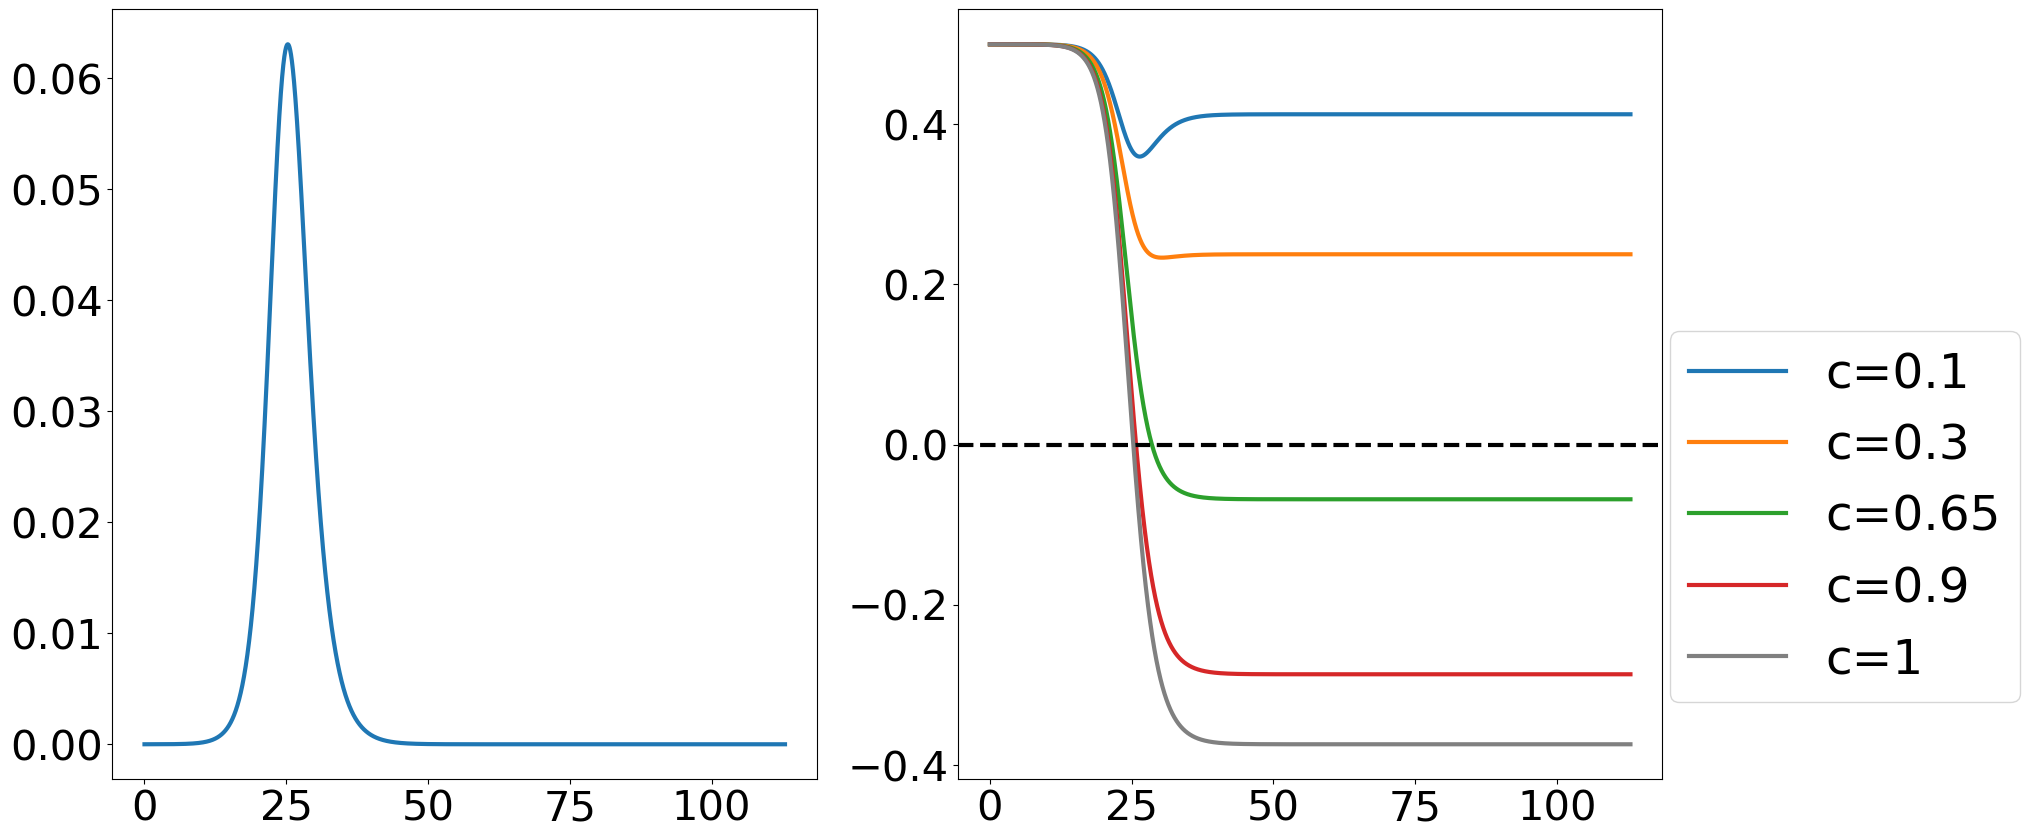

In [14]:
fig,ax= plt.subplots(1,2,figsize=(20,10))

ax[0].plot(ts,y)
# ax[0].set_xlim((0,20))
# ax[1].set_xlim((0,20))
# z= 
for c in [.1,.3,.65,.9]:
    fit =  R0 * ( x + (1- c)*z )-1
    ax[1].plot(ts,fit,label = f'c={c}')
ax[1].axhline(0,linestyle='--',color='black')
ax[1].plot(ts, R0 * x -1, label = 'c=1',color='grey')
ax[1].legend(loc=(1.01,.1))

In [15]:
xi in xi*np.logspace(-1,1,20)

False

In [16]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [17]:
R0, kappa = 2.5, 1e4
N = 1e7
xi = 50
ds = xi*np.logspace(-1,1,21)

muN=1000
R_d = lambda d, dbar: np.exp(-(d-1)/dbar)
dbar=  10
R_d
ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]
dt = ts[1]-ts[0]

fit_d = lambda x,y,z, d_over_xi: R0/(1+y*kappa) * ( x + (1- np.exp(-d_over_xi))*z )-1
sel_d = lambda x,y,z,d_over_xi: fit_d(x,y,z,d_over_xi) - fit_d(x,y,z,0)


simple_sel = lambda z, d_over_xi: (1-np.exp(-d_over_xi))*z#/(1-z)

p_surv = lambda x,y,z, d_over_xi: get_p_surv_inv_int(fit_d(x,y,z,d_over_xi=d_over_xi), dt=dt,reg= 1e-1)

def plot_f_s_pi(ax, x,y,z, ts, ds, xi, legend_fontsize=20, tqdm_disabled=False):
    tp = ts[np.argmax(y)]

    for d in tqdm(ds,disable=tqdm_disabled):
        fit = fit_d(x,y,z,d/xi)
        sel = sel_d(x,y,z,d/xi)

        line_d, = ax.plot(ts,fit, label = fr'$\frac{{d}}{{\xi}}={d/xi:.2f}$',alpha=.5)

        line_sel, = ax.plot(ts,sel,  color = line_d.get_color(), linestyle='--')#,label = f'sel d={d}',)

        ax.plot(ts,p_surv(x,y,z,d/xi),  color = line_d.get_color(), linestyle=':')#,label = f'p_surv d={d}',)
        ax.plot(ts,sel/(1+sel),  color = line_d.get_color(), linestyle='-.')#,label = f'p_surv d={d}',)
    
    handles= ax.get_legend_handles_labels()[0]
    handles = handles +[
        Line2D([0], [0], color='k', lw=2, label='fit'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label='selection'),
        Line2D([0], [0], color='k', lw=2, linestyle=':', label=r'$\pi_d(t)$ (inhomogeneous branching)'),
    ]

    # ax.legend(handles=handles,loc='best', fontsize=legend_fontsize)
    ax.axvline(tp, color='k', linestyle='--')

    ax.set_xscale('log')
    ax.set_yscale('log')

def plot_y_psurv(ax, x,y,z, ts, ds, xi, legend_fontsize=20, tqdm_disabled=False):
    tp = ts[np.argmax(y)]
    for d in tqdm(ds,disable=tqdm_disabled):
            fit = fit_d(x,y,z,d/xi)
            sel = sel_d(x,y,z,d/xi)

            line_y_psurv, = ax.plot(ts,y * p_surv(x,y,z,d/xi), linestyle=':')#,label = f'p_surv d={d}',)
            ax.plot(ts,y * sel/(1+sel),  color = line_y_psurv.get_color(), linestyle='-.')#,label = f'p_surv d={d}',)
            ax.plot(ts,y * sel,  color = line_y_psurv.get_color(), linestyle='--',alpha=.5)#,label = f'p_surv d={d}',)

    handles= []

    handles = handles +[
    Line2D([0], [0], color='k', lw=2, linestyle=':', label=r'$y(t) \pi_d(t)$ (inhomogeneous branching)'),
    Line2D([0], [0], color='k', lw=2, linestyle='-.', label=r'$y(t) \frac{s_d(t)}{1 + s_d(t)}$ (adiabatic)'),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$y(t) s_d(t)$'),
]
    ax.axvline(tp, color='k', linestyle='--')
    # ax.legend(handles=handles,loc='best', fontsize=legend_fontsize)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-8,1e-4)

def plot_integral_y_psurv(ax, x,y,z, ts, ds, xi, legend_fontsize=20, tqdm_disabled=False, logscales =False, return_fits = False):
    tp = ts[np.argmax(y)]
    dt = ts[1]-ts[0]
    list_fits = []
    for d in tqdm(ds,disable=tqdm_disabled):
            fit = fit_d(x,y,z,d/xi)
            sel = sel_d(x,y,z,d/xi)
            cum_y_p_surv = np.cumsum(y * p_surv(x,y,z,d/xi))*dt
            #fit cum_y_p_surv with quadratic
            line_y_psurv, = ax.plot(ts[cum_y_p_surv<np.max(cum_y_p_surv)], cum_y_p_surv[cum_y_p_surv<np.max(cum_y_p_surv)], linestyle='-',alpha=.5)#,label = f'p_surv d={d}',

            p = np.polyfit(ts[cum_y_p_surv<np.max(cum_y_p_surv)*.75], cum_y_p_surv[cum_y_p_surv<np.max(cum_y_p_surv)*.75], 2)
            list_fits.append(p)

            ax.plot(ts, np.polyval(p,ts), linestyle=':', color = line_y_psurv.get_color(), alpha=.5)
            
            ax.plot(ts,np.cumsum(y * sel/(1+sel)*dt),  color = line_y_psurv.get_color(), linestyle='-.', alpha=.5)#,label = f'p_surv d={d}',)

            sim_sel = simple_sel(z,d/xi)
            sim_pi = sim_sel/(1+sim_sel)
            ax.plot(ts,np.cumsum(y * sim_sel*dt),  color = line_y_psurv.get_color(), linestyle='-.', alpha=.5,marker='x', markevery=1000)#,label = f'p_surv d={d}',)

            # ax.plot(ts,np.cumsum(y * sel*dt),  color = line_y_psurv.get_color(), linestyle='--',alpha=.5)#,label = f'p_surv d={d}',)

    # ax.plot(ts, ts/(6*N), color='k', linestyle='--')
    ax.plot(ts, ts**2/(500*N), color='k', linestyle=':')

    # ax.annotate(r'$\sim t$', (ts[len(ts)//10], ts[len(ts)//10]*(1.5)/(4*N)), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)
    ax.annotate(r'$\sim t^2$', (ts[len(ts)//10], ts[len(ts)//10]**2*(1.5)/(4*N)), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)

    handles= []

    handles = handles +[
    Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$\int_0^t y(t) \pi_d(t) dt$ (inhomogeneous branching)'),
    Line2D([0], [0], color='k', lw=2, linestyle='-.', label=r'$\int_0^t y(t) \frac{s_d(t)}{1 + s_d(t)} dt$ (adiabatic)'),
    Line2D([0], [0], color='k', lw=2, linestyle=':', label='quadratic fit'),
    # Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$\int_0^t y(t) s_d(t) dt$'),

]
    ax.axvline(tp, color='k', linestyle='--')
    ax.legend(handles=handles,loc=(1.01,.1), fontsize=legend_fontsize)

    if logscales:
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.set_ylim(bottom= 0,top=.35)
        ax.set_xlim(left=ts[1], right=5*kappa/R0)
    if return_fits:
        return np.array(list_fits)

 19%|█▉        | 4/21 [00:00<00:00, 740.72it/s]


TypeError: expected non-empty vector for x

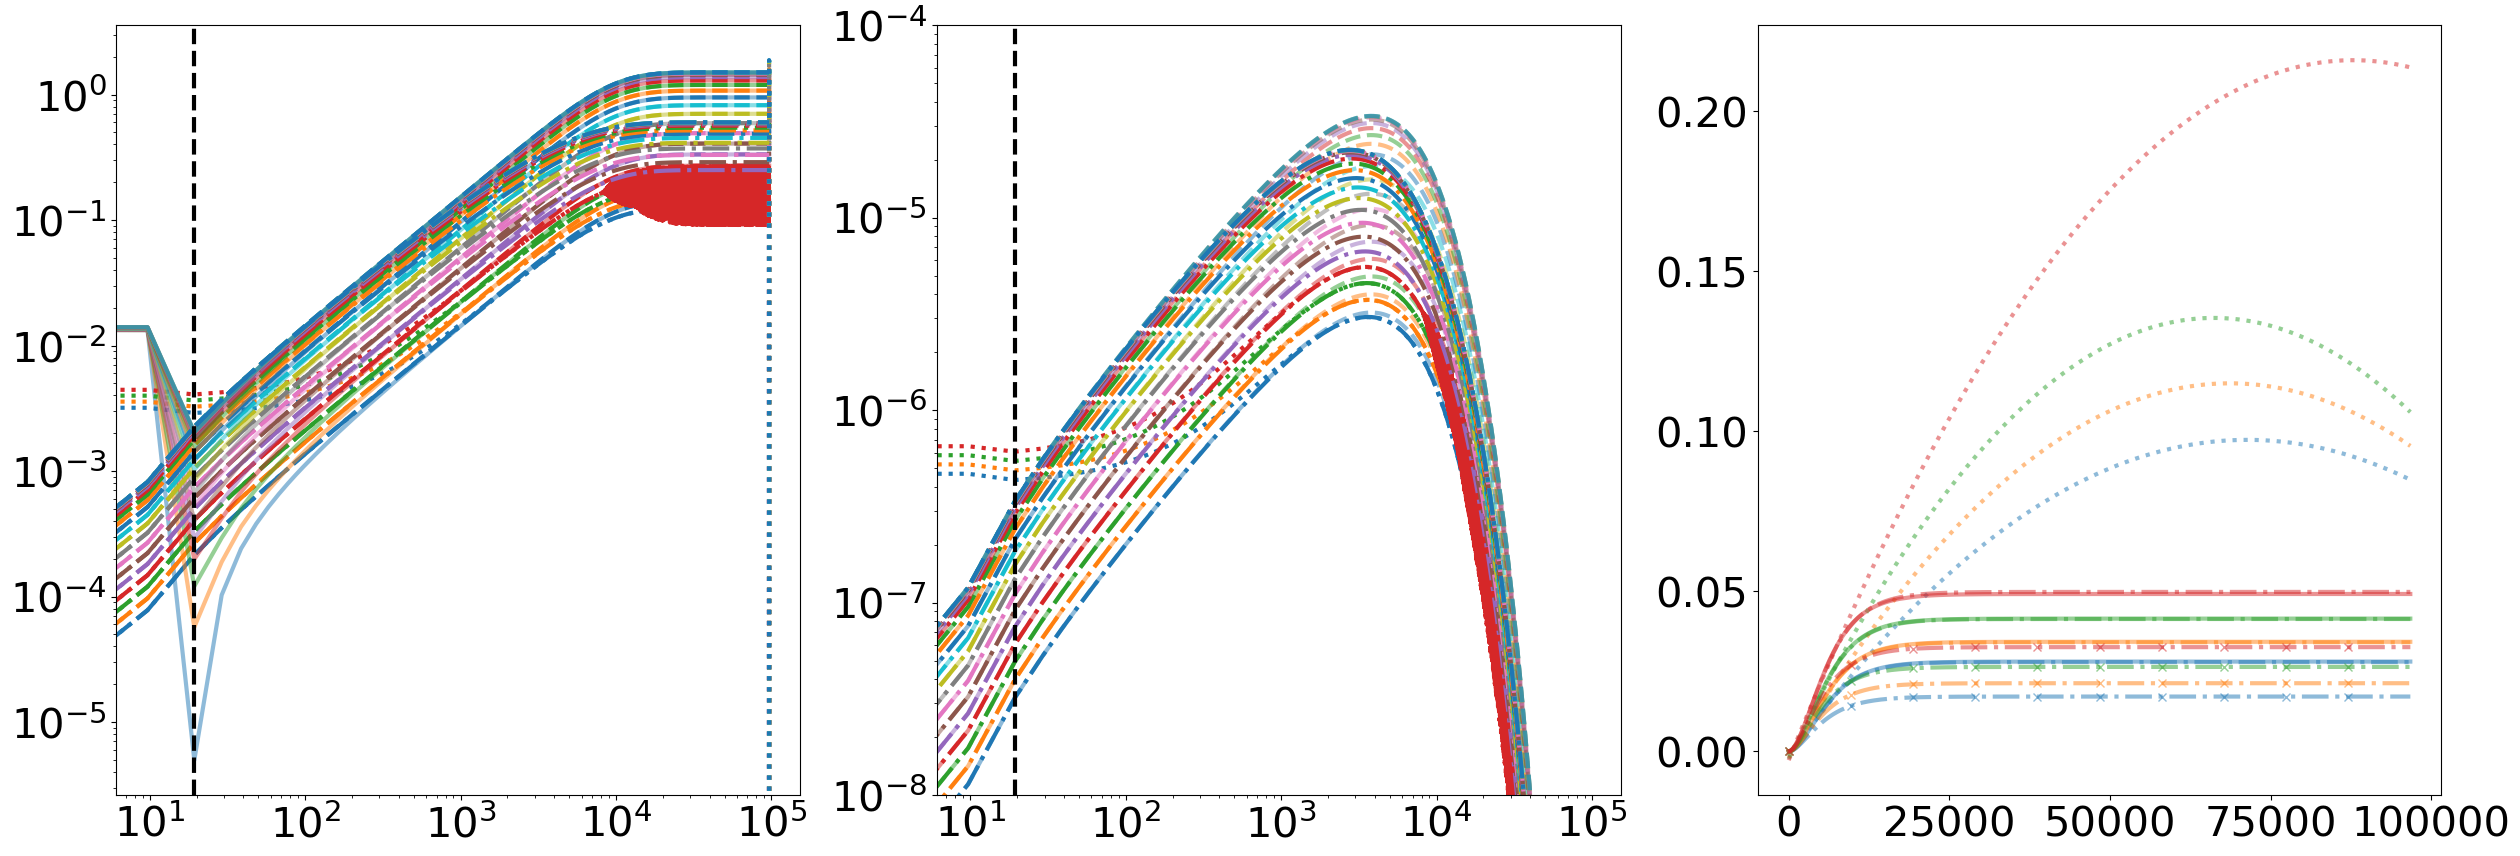

In [19]:

fig,ax = plt.subplots(1,3,figsize=(30,10))

plot_f_s_pi(ax[0], x,y,z, ts, ds, xi)
plot_y_psurv(ax[1], x,y,z, ts, ds, xi, legend_fontsize=20)
plot_integral_y_psurv(ax[2], x,y,z, ts, ds, xi, legend_fontsize=20,logscales=False)
# ax[2].set_xscale('log')



/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_4412/1416405851.py:109: RuntimeWarning: divide by zero encountered in log
  tfix_exact_s = lambda t, d_over_xi, R0,kappa,sel_fun : np.sqrt(t**2+2*kappa/R0 /((1-c_d(d_over_xi))*zinf(R0,kappa))*np.log(N*yp(R0,kappa)*sel_fun(t)))
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_4412/1416405851.py:109: RuntimeWarning: invalid value encountered in sqrt
  tfix_exact_s = lambda t, d_over_xi, R0,kappa,sel_fun : np.sqrt(t**2+2*kappa/R0 /((1-c_d(d_over_xi))*zinf(R0,kappa))*np.log(N*yp(R0,kappa)*sel_fun(t)))


Text(0.5, 0.95, '$R_0=2.5, \\kappa=1e+03,\\mu N=1e+03, \\langle d \\rangle/\\xi=0.2$')

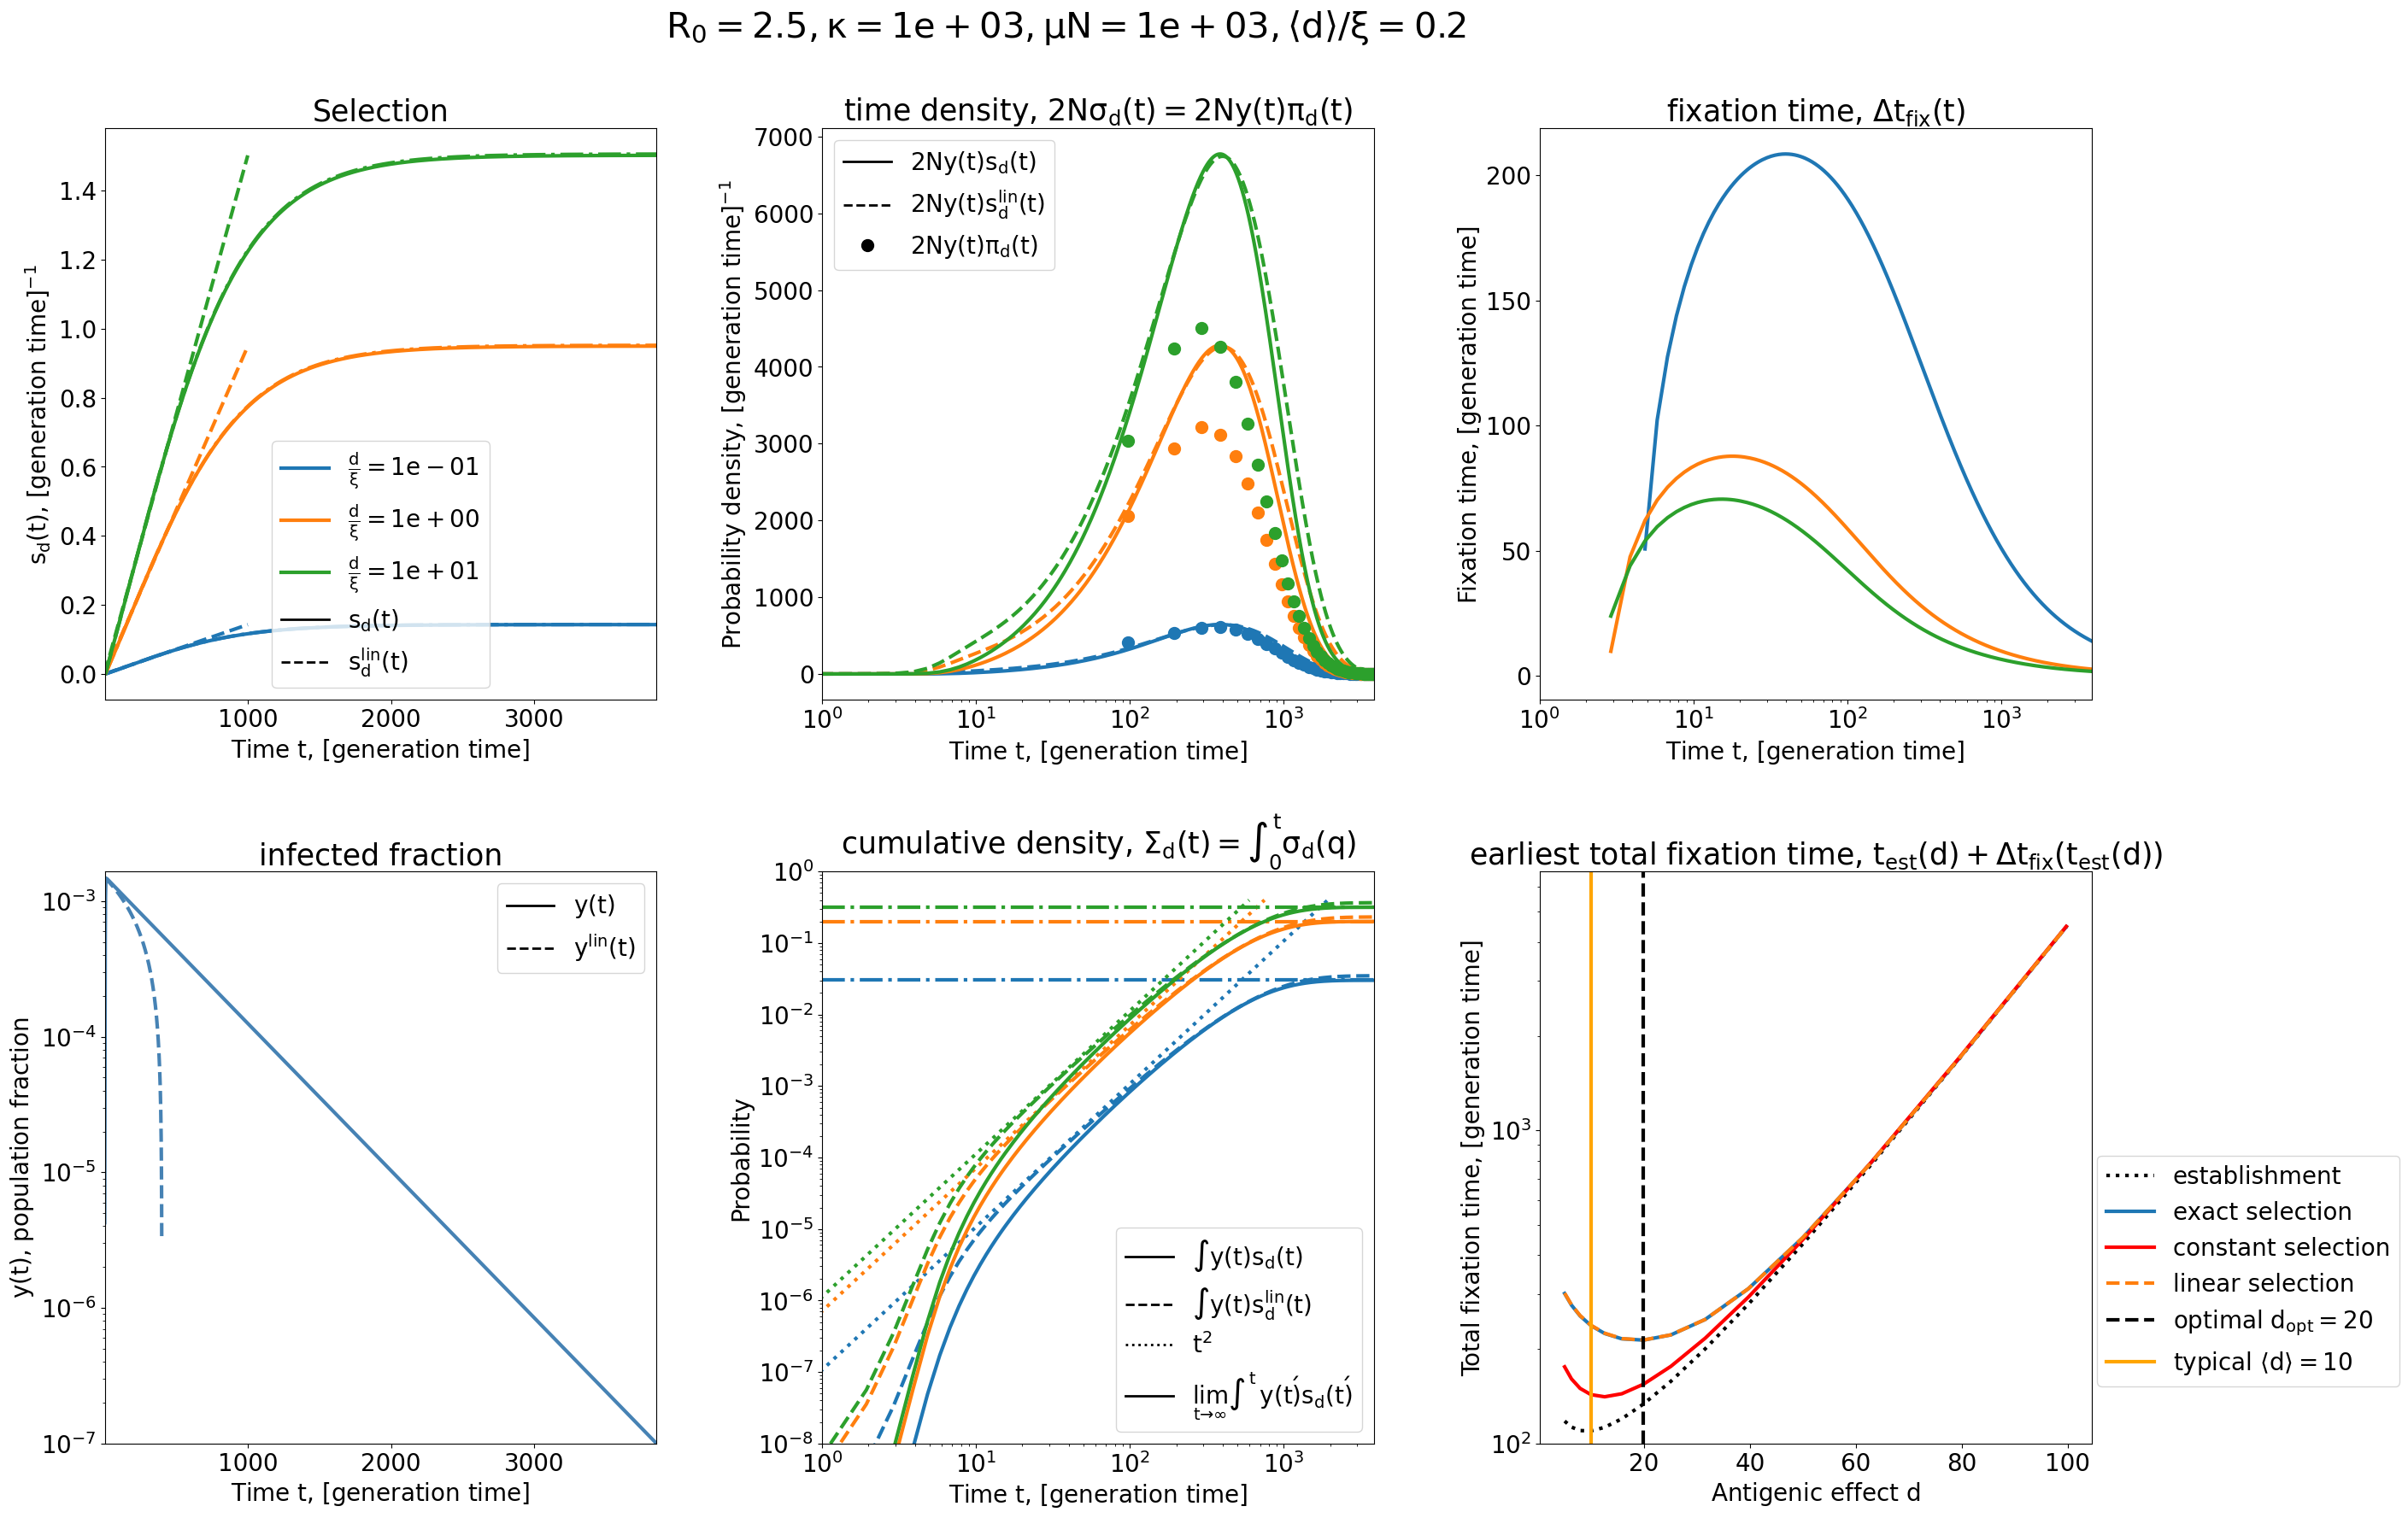

In [20]:
# zp = lambda R0,kappa: R0/kappa * (np.log((R0-1)*kappa**2 /(R0**2))- (R0-1)/R0)
zp = lambda R0,kappa: 0
yp = lambda R0,kappa: (R0-1)/kappa
zinf= lambda R0,kappa: 1- 1/R0 + 1/kappa
c_d= lambda d_over_xi: np.exp(-d_over_xi)

R0, kappa = 2.5, 1e3
muN= 1000

ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]
dt = ts[1]-ts[0]

ds_few = xi*np.logspace(-1,1,3)

fig,ax = plt.subplots(2,3,figsize=(30,20))
ax= ax.T.flatten()
plt.subplots_adjust(hspace=.3, wspace=.3)

# -zp (-1 + c[d]) - (R0 t (zinf - zp) (-1 + c[d]))/\[Kappa]
c_d = lambda d_over_xi: np.exp(-d_over_xi)
lin_sel_d = lambda t, d_over_xi, R0,kappa: zp(R0,kappa) * (1 - c_d(d_over_xi)) \
    + (R0 * t * (zinf(R0,kappa) - zp(R0,kappa)) * (1 - c_d(d_over_xi)))/kappa

lin_sel_2_d = lambda t, d_over_xi, R0,kappa: (1-c_d(d_over_xi)) *(zinf(R0,kappa)*R0*t/kappa)/(1-(1-c_d(d_over_xi)) *(zinf(R0,kappa)*R0*t/kappa))

sel_lin_z_d = lambda z, d_over_xi: (1 - c_d(d_over_xi)) *z/(1-z)
T = np.min(ts[y<1/N])
    
for d in ds_few:
    sel = sel_d(x,y,z,d/xi)
    ls = ax[0].plot(ts,sel, label = fr'$\frac{{d}}{{\xi}}={d/xi:.0e}$')
    
    sel_lin_z = sel_lin_z_d(z,d/xi)
    ax[0].plot(ts,sel_lin_z, color = ls[0].get_color(), linestyle='-.')

    lin_sel = lin_sel_d(ts, d/xi, R0, kappa)
    ax[0].plot(ts[lin_sel<np.max(sel)],lin_sel[lin_sel<np.max(sel)], color = ls[0].get_color(), linestyle='--')

ylin = yp(R0,kappa)*(1-R0/kappa*ts)
yquad = yp(R0,kappa)*(1-R0/kappa*ts + R0**2/(2*kappa**2)*ts**2- R0**3/(6*kappa**3)*ts**3)

ax[1].plot(ts,y,color='steelblue',linestyle='-')
ax[1].plot(ts[ylin>0],ylin[ylin>0],color='steelblue',linestyle='--')

ax[1].set_yscale('log')
ax[1].set_ylim(1/N,yp(R0,kappa)*1.1)



peaks_prod = []
for d in ds_few:
    sel = sel_d(x,y,z,d/xi)
    psurv = p_surv(x,y,z,d/xi)
    ls = ax[2].plot(ts,2*N*y*sel)
    ax[2].plot(ts,2*N*y*psurv, color = ls[0].get_color(), linestyle='', marker='o',ms=10, markevery=100)
    peaks_prod.append(ts[np.argmax(y*sel)])

    lin_sel = lin_sel_d(ts, d/xi, R0, kappa)

    qprod = y*lin_sel
    ax[2].plot(ts[qprod>0],2*N*qprod[qprod>0], color = ls[0].get_color(), linestyle='--')

# ax[2].set_xscale('log')  
# ax[2].set_yscale('log')
# ax[2].set_ylim(1e-8,1e-2)

for id,d in enumerate(ds_few):
    sel = sel_d(x,y,z,d/xi)
    fit= fit_d(x,y,z,d/xi)

    psurv = p_surv(x,y,z,d/xi)

    ls = ax[3].plot(ts,np.cumsum(y*sel)*dt, label = fr'$\frac{{d}}{{\xi}}={d/xi:.2f}$')
    # ax[3].plot(ts,np.cumsum(y*psurv)*dt, color = ls[0].get_color(), linestyle='', marker='o',ms=10, markevery=1000)

    lin_sel = lin_sel_d(ts, d/xi, R0, kappa)

    qcumprod = np.cumsum(y*lin_sel)*dt
    ax[3].plot(ts[qcumprod>0],qcumprod[qcumprod>0], color = ls[0].get_color(), linestyle='--')
    limiting_value = (1-np.exp(-d/xi))*(-zinf(R0,kappa)-np.log(1-zinf(R0,kappa)))
    qcumprod_analytical = R0* ts**2/(2*kappa) *(1- np.exp(-d/xi))*yp(R0,kappa)*zinf(R0,kappa)
    
    ax[3].plot(ts[
        np.logical_and(qcumprod_analytical>0,qcumprod_analytical<.4)],qcumprod_analytical[
        np.logical_and(qcumprod_analytical>0,qcumprod_analytical<.4)], color = ls[0].get_color(), linestyle=':')
    
    
    ax[3].axhline(limiting_value, color=ls[0].get_color(), linestyle='-.')

    # ax[3].axvline(peaks_prod[0], color=ls[0].get_color(), linestyle='--')
    # ax[1].axvline(peaks_prod[0], color=ls[0].get_color(), linestyle='--')
    # ax[0].axvline(peaks_prod[0], color=ls[0].get_color(), linestyle='--')
    # ax[2].axvline(peaks_prod[0], color=ls[0].get_color(), linestyle='--')

    test_d = 1/np.sqrt(muN*yp(R0,kappa)*R_d(d,dbar)*(1-c_d(d/xi))*zinf(R0,kappa)*R0/(2*kappa))
    # if test_d<ts[-1]:
        # ax[2].axvline(test_d, linestyle=':', label = fr'$\frac{{d}}{{\xi}}={d/xi:.2f}$', color=ls[0].get_color())

# ax[3].plot(ts, ts**2/(500*N), color='k', linestyle=':')
ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_ylim(1e-8,1e-0)


plt.gca().set_prop_cycle(None)
tfix_exact_s = lambda t, d_over_xi, R0,kappa,sel_fun : np.sqrt(t**2+2*kappa/R0 /((1-c_d(d_over_xi))*zinf(R0,kappa))*np.log(N*yp(R0,kappa)*sel_fun(t)))
tfix_exact_s_list = []
tfix_constant_s = lambda t, d_over_xi, R0,kappa,sel_fun : t+ 1/(1-c_d(d_over_xi))*np.log(N*yp(R0,kappa)*sel_fun(t))
tfix_constant_s_list = []

tfix_lin_s = lambda t, d_over_xi, R0,kappa: np.sqrt(t**2+2*kappa/R0 /((1-c_d(d_over_xi))*zinf(R0,kappa))*np.log(N*yp(R0,kappa)*lin_sel_d(t,d_over_xi, R0, kappa)))
tfix_lin_s_list = []

for d in ds:
    test_d = 1/np.sqrt(muN*yp(R0,kappa)*R_d(d,dbar)*(1-c_d(d/xi))*zinf(R0,kappa)*R0/(2*kappa))
    sel = sel_d(x,y,z,d/xi)
    sel_interpol = spi.interp1d(ts,sel,fill_value='extrapolate')

    tfix = tfix_exact_s(ts, d/xi, R0, kappa, sel_interpol)

    if d in ds_few: lf, = ax[4].plot(ts, tfix-ts, label = fr'$\frac{{d}}{{\xi}}={d/xi:.2f}$')
    if test_d<ts[-1]:
        # if d in ds_few: ax[4].axvline(test_d, linestyle=':', label = fr'$\frac{{d}}{{\xi}}={d/xi:.2f}$', color=lf.get_color())
        tfix_test = tfix_exact_s(test_d, d/xi, R0, kappa, sel_interpol)
        tfix_constant_s_test = tfix_constant_s(test_d, d/xi, R0, kappa, sel_interpol)
        tfix_lin_s_test = tfix_lin_s(test_d, d/xi, R0, kappa)

        # ax[-1].scatter(d,test_d, color=lf.get_color())

    else:
        tfix_test = np.inf
        tfix_constant_s_test = np.inf
        tfix_lin_s_test = np.inf
    tfix_exact_s_list.append(tfix_test)
    tfix_constant_s_list.append(tfix_constant_s_test)
    tfix_lin_s_list.append(tfix_lin_s_test)
    

tfix_exact_s_list= np.array(tfix_exact_s_list)

test_list = [1/np.sqrt(muN*yp(R0,kappa)*R_d(d,dbar)*(1-c_d(d/xi))*zinf(R0,kappa)*R0/(2*kappa))  if 1/np.sqrt(muN*yp(R0,kappa)*R_d(d,dbar)*(1-c_d(d/xi))*zinf(R0,kappa)*R0/(2*kappa))<ts[-1] else np.inf for d in ds]
ax[-1].plot(ds,test_list, linestyle=':', color='k',label = 'establishment')

ax[-1].plot(ds,tfix_exact_s_list,label = 'exact selection')
ax[-1].plot(ds,tfix_constant_s_list,label = 'constant selection',color='red')
ax[-1].plot(ds,tfix_lin_s_list,label = 'linear selection', linestyle='--')

dopt = ds[np.argmin(tfix_exact_s_list[~np.isinf(tfix_exact_s_list)])]
ax[-1].axvline(dopt, color='k', linestyle='--',label='optimal '+ fr'$d_\mathrm{{opt}}={dopt:.0f}$')
ax[-1].axvline(dbar,color='orange',label='typical '+ fr'$\langle d \rangle={dbar}$')

ax[-1].legend(loc=(1.01,.1), fontsize=20)

ax[-1].set_ylim(1e2,np.max(tfix_exact_s_list[~np.isinf(tfix_exact_s_list)])*1.5)

ax[-1].set_yscale('log')

handles0 = ax[0].get_legend_handles_labels()[0]
handles0+=[
    Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$s_d(t)$'),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$s^\mathrm{lin}_d(t)$'),
]
ax[0].legend(handles=handles0,loc='best', fontsize=20)

handles1 = ax[1].get_legend_handles_labels()[0]
handles1=[
    Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$y(t)$'),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$y^\mathrm{lin}(t)$'),
]
ax[1].legend(handles=handles1,loc='best', fontsize=20)

handles2 = ax[2].get_legend_handles_labels()[0]
handles2=[
    Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$2N y(t)s_d(t)$'),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$2N y(t)s^\mathrm{lin}_d(t)$'),
    Line2D([0], [0], color='k', lw=2, linestyle='',marker='o',ms=10, label=r'$2N y(t)\pi_d(t)$'),
]
ax[2].legend(handles=handles2,loc='best', fontsize=20)

handles3 = [
    Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$\int y(t)s_d(t)$'),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$\int y(t)s^\mathrm{lin}_d(t)$'),
    Line2D([0], [0], color='k', lw=2, linestyle=':', label=r'$t^2$'),
    Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$\lim_{t\to\infty} \int^t y(t\')s_d(t\')$'),
]
ax[3].legend(handles=handles3,loc='best', fontsize=20)

subtitles_fontsize=25
ax[0].set_title('Selection', fontsize=subtitles_fontsize)
ax[0].set_ylabel(r'$s_d(t)$, [generation time]$^{-1}$', fontsize=20)

ax[1].set_title('infected fraction', fontsize=subtitles_fontsize)
ax[1].set_ylabel(r'$y(t)$, population fraction', fontsize=20)

ax[2].set_title(r'time density, $2 N \sigma_d(t) =  2 N y(t) \pi_d(t)$', fontsize=subtitles_fontsize)
ax[2].set_ylabel(r'Probability density, [generation time]$^{-1}$', fontsize=20)

ax[3].set_title(r'cumulative density, $\Sigma_d(t)= \int_0^t\sigma_d(q)$', fontsize=subtitles_fontsize)
ax[3].set_ylabel(r'Probability', fontsize=20)

ax[4].set_title(r'fixation time, $\Delta t_{\mathrm{fix}}(t)$', fontsize=subtitles_fontsize)
ax[4].set_ylabel(r'Fixation time, [generation time]', fontsize=20)

ax[-1].set_title(r'earliest total fixation time, $ t_\mathrm{est}(d) + \Delta t_{\mathrm{fix}}(t_\mathrm{est}(d))$', fontsize=subtitles_fontsize)
ax[-1].set_ylabel(r'Total fixation time, [generation time]', fontsize=20)


for ia, a in enumerate(ax[:-1]):
    a.set_xlabel(r'Time $t$, [generation time]', fontsize=20)
    if ia>1: a.set_xscale('log')
    a.tick_params(axis='both', which='major', labelsize=20)

    a.set_xlim(1,T)
ax[-1].set_xlabel(r'Antigenic effect $d$', fontsize=20)
ax[-1].tick_params(axis='both', which='major', labelsize=20)

fig.suptitle(fr'$R_0={R0}, \kappa={kappa:.0e},\mu N={muN:.0e}, \langle d \rangle/\xi={dbar/xi:.1f}$', fontsize=30, y=.95)
# plt.savefig(output_folder+f'est_and_selection_recap_R0_{R0}_kappa_{kappa:.0e}_muN_{muN:.0e}_dbar_{dbar}.pdf',bbox_inches='tight')


In [21]:
sel

array([0.00000000e+00, 5.42307643e-06, 2.79144954e-05, ...,
       1.50243179e+00, 1.50243179e+00, 1.50243179e+00])

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_4412/3638454741.py:208: RuntimeWarning: divide by zero encountered in log
  tf_d = np.log(N*y*sel)/(sel)
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_4412/3638454741.py:211: RuntimeWarning: divide by zero encountered in log
  tf_lin = np.log(N*y*sel_lin)/(sel_lin)


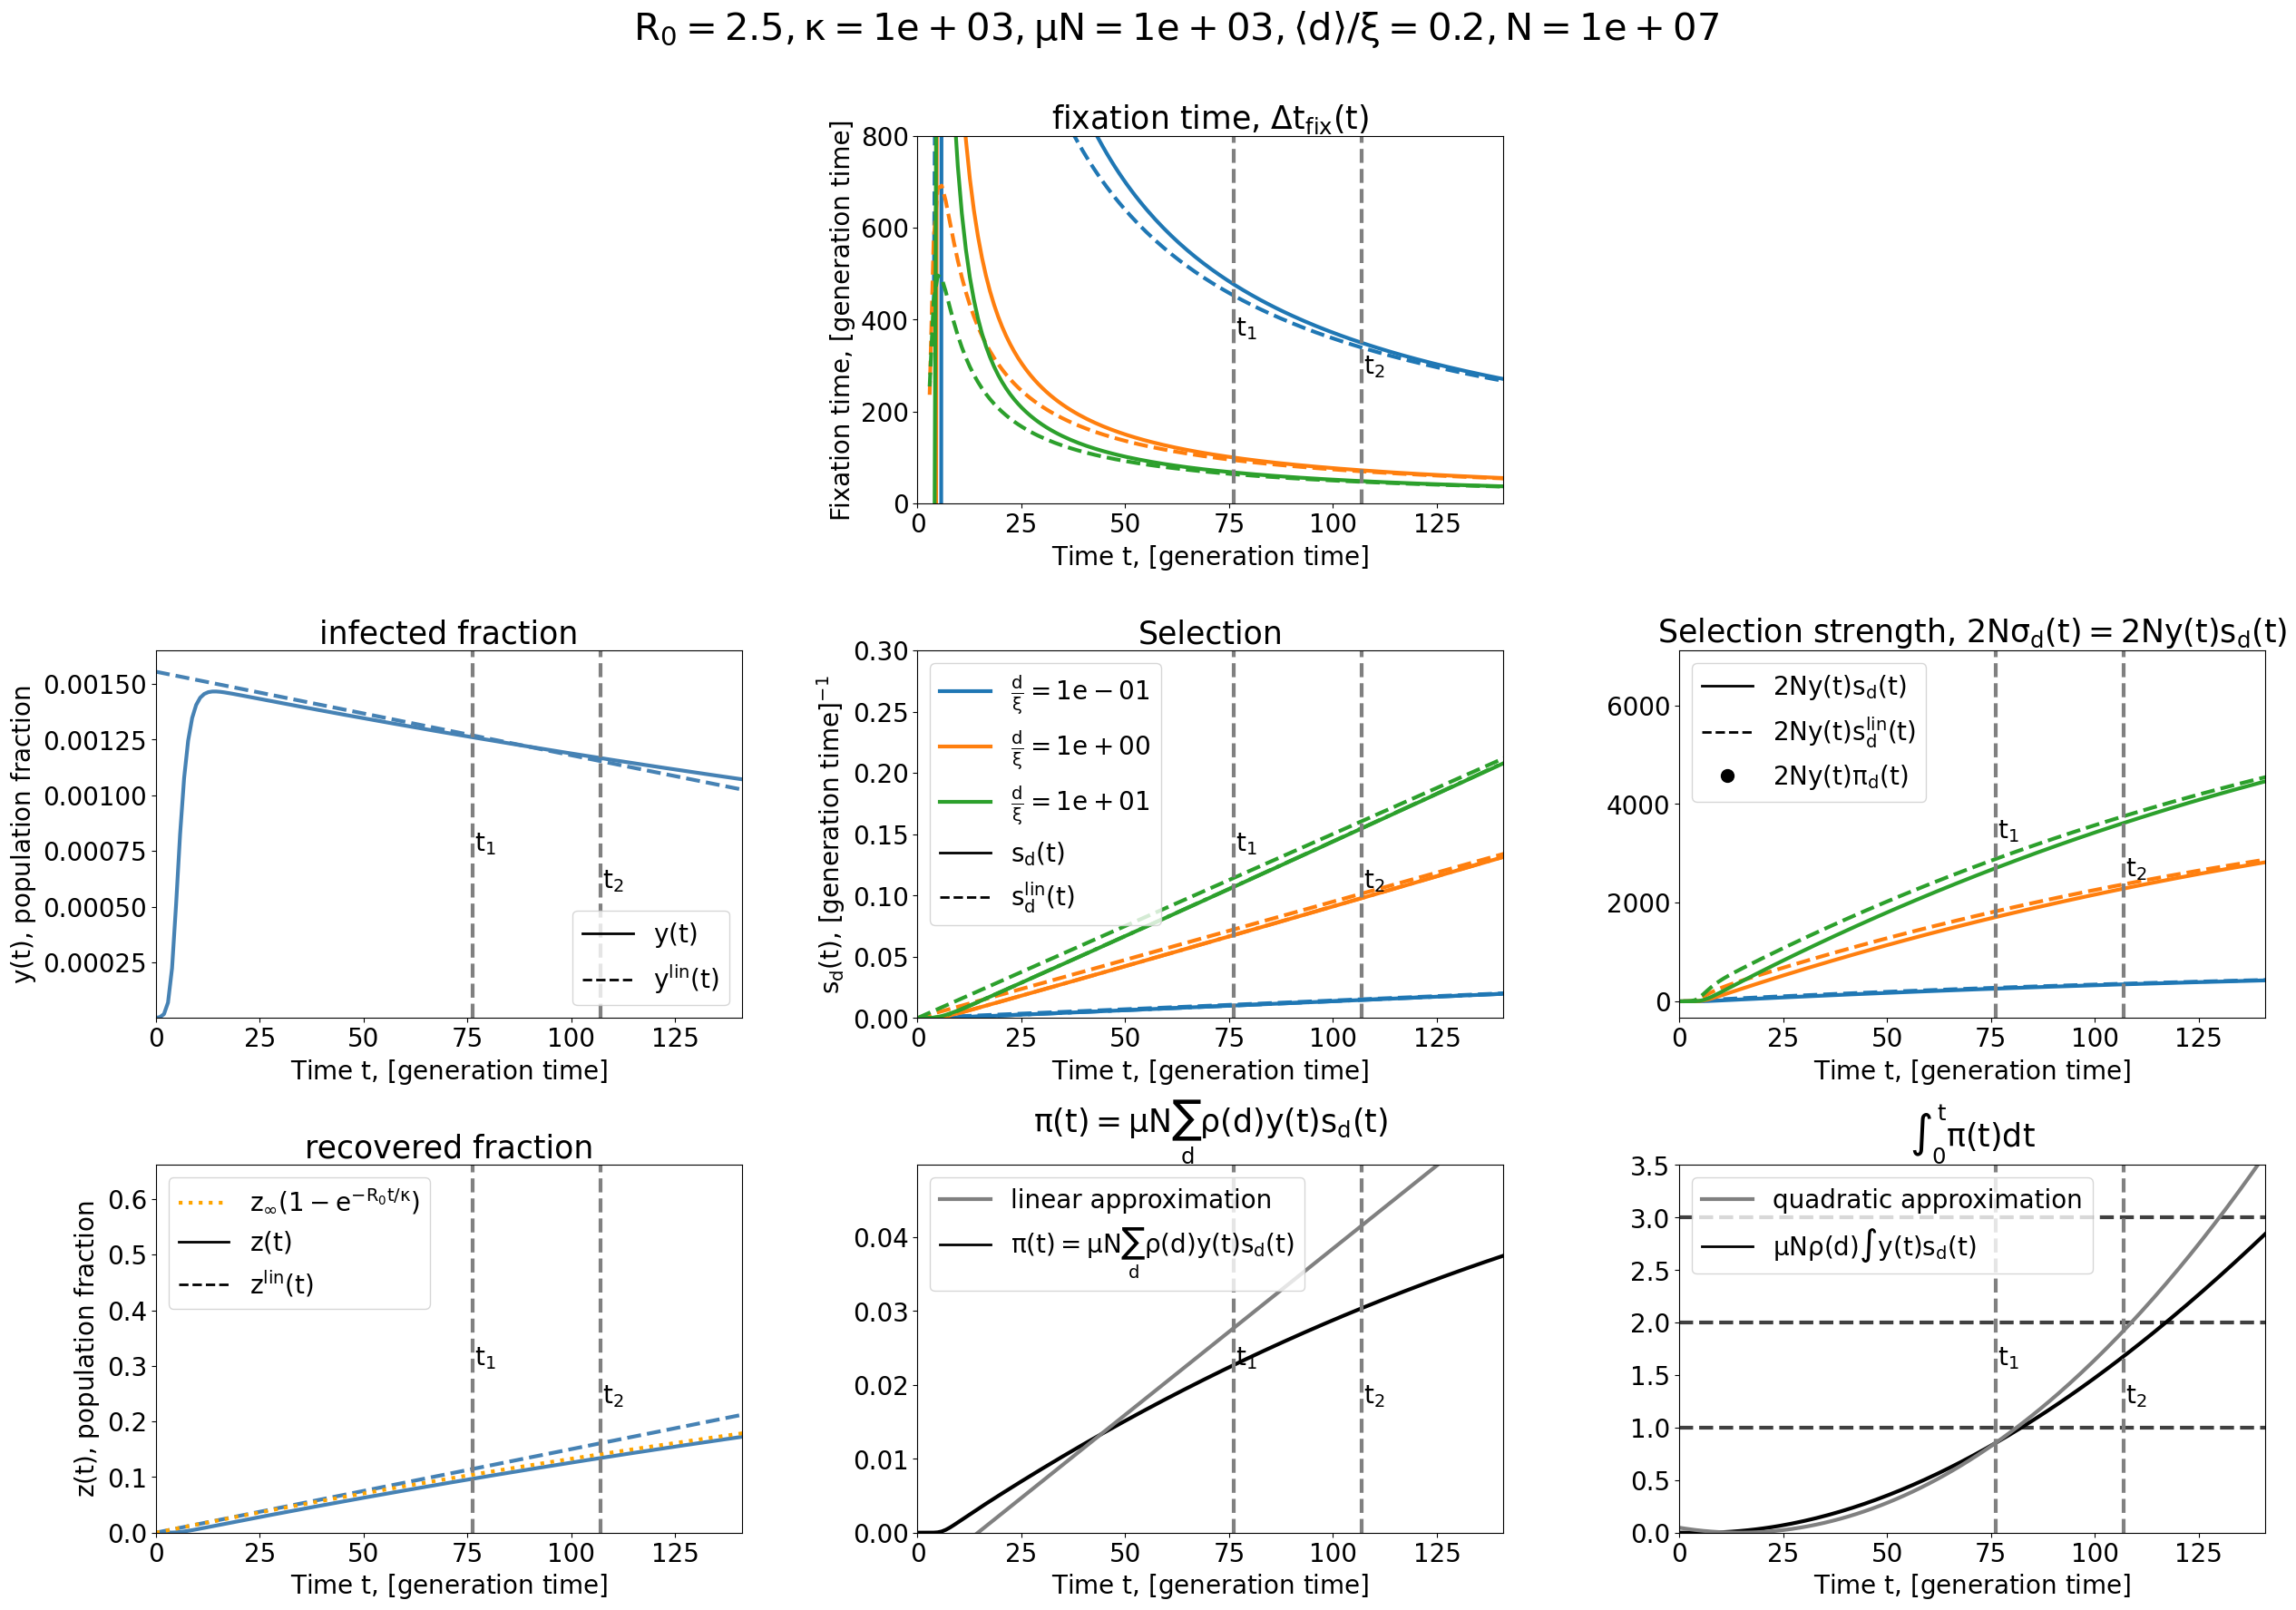

In [22]:
# zp = lambda R0,kappa: R0/kappa * (np.log((R0-1)*kappa**2 /(R0**2))- (R0-1)/R0)
zp = lambda R0,kappa: 0
yp = lambda R0,kappa: (R0-1)/kappa
zinf= lambda R0,kappa: 1- 1/R0 + 1/kappa
c_d= lambda d_over_xi: np.exp(-d_over_xi)
sel_d = lambda x,y,z,d_over_xi: fit_d(x,y,z,d_over_xi) - fit_d(x,y,z,0)

R0, kappa = 2.5, 1e3
muN= 1000
p_alpha= .1
subtitles_fontsize=25

ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]
dt = ts[1]-ts[0]

ds_few = xi*np.logspace(-1,1,3)
ds_range= np.arange(1,20*dbar)


alpha = muN*(R0-1)**2 /kappa**2 
delta =dbar/xi
corr_delta = (np.exp(2/dbar)*(-1 + np.exp(1/xi)))/(dbar*(-1 + np.exp(1/dbar))*(-1 + np.exp(1/dbar + 1/xi)))
    
t1 = np.sqrt(np.pi/(2*alpha*corr_delta))
t2 = np.sqrt(9/8 * np.pi/(alpha*corr_delta))


# -zp (-1 + c[d]) - (R0 t (zinf - zp) (-1 + c[d]))/\[Kappa]
c_d = lambda d_over_xi: np.exp(-d_over_xi)
lin_sel_d = lambda t, d_over_xi, R0,kappa: zp(R0,kappa) * (1 - c_d(d_over_xi)) \
    + (R0 * t * (zinf(R0,kappa) - zp(R0,kappa)) * (1 - c_d(d_over_xi)))/kappa

lin_sel_2_d = lambda t, d_over_xi, R0,kappa: (1-c_d(d_over_xi)) *(zinf(R0,kappa)*R0*t/kappa)/(1-(1-c_d(d_over_xi)) *(zinf(R0,kappa)*R0*t/kappa))

sel_lin_z_d = lambda z, d_over_xi: (1 - c_d(d_over_xi)) *z/(1-z)
T = np.min(ts[y<1/N])
pi_summed = np.zeros_like(ts)
pi_lin_summed = np.zeros_like(ts)
for id,d in enumerate(ds_range):
    sel = sel_lin_z_d(z,d/xi)
    sel_lin = lin_sel_2_d(ts, d/xi, R0, kappa)

    fit= fit_d(x,y,z,d/xi)
    rho_d = p_alpha*(1-p_alpha)**(d-1)
    pi_summed+= muN*y*sel*rho_d
    pi_lin_summed+= muN*y*sel_lin*rho_d

lowest_order= True


fig,ax = plt.subplots(3,3,figsize=(30,20))
ax= np.roll(ax.flatten(),-3)
plt.subplots_adjust(hspace=.4, wspace=.3)

block_axinf= True
axinf = ax[0]
##axinf --> Infected
if block_axinf:
    ylin = yp(R0,kappa)*(1-R0/kappa*(ts-tp))
    yquad = yp(R0,kappa)*(1-R0/kappa*ts + R0**2/(2*kappa**2)*ts**2- R0**3/(6*kappa**3)*ts**3)

    axinf.plot(ts,y,color='steelblue',linestyle='-')
    axinf.plot(ts[ylin>0],ylin[ylin>0],color='steelblue',linestyle='--')

    # axinf.set_yscale('log')
    axinf.set_ylim(1/N,yp(R0,kappa)*1.1)

    axinf.set_title('infected fraction', fontsize=subtitles_fontsize)
    axinf.set_ylabel(r'$y(t)$, population fraction', fontsize=20)

    handles0 = axinf.get_legend_handles_labels()[0]
    handles0=[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$y(t)$'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$y^\mathrm{lin}(t)$'),
    ]
    axinf.legend(handles=handles0,loc='best', fontsize=20)

##axrec --> Recovered
block_axrec= True
axrec = ax[3]
if block_axrec:
    zlin = zinf(R0,kappa)*(R0/kappa*ts)
    axrec.plot(ts,z,color='steelblue',linestyle='-')
    axrec.plot(ts[zlin<zinf(R0,kappa)],zlin[zlin<zinf(R0,kappa)],color='steelblue',linestyle='--')
    axrec.plot(ts, zinf(R0,kappa) *(1- np.exp(-R0/kappa*ts)), color='orange', linestyle=':', label=r'$z_\infty\left(1- e^{-R_0 t/\kappa}\right)$')
    # axrec.set_yscale('log')
    axrec.set_ylim(-1/N,zinf(R0,kappa)*1.1)

    axrec.set_title('recovered fraction', fontsize=subtitles_fontsize)
    axrec.set_ylabel(r'$z(t)$, population fraction', fontsize=20)

    handles1 = axrec.get_legend_handles_labels()[0]
    handles1+=[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$z(t)$'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$z^\mathrm{lin}(t)$'),
    ]
    axrec.legend(handles=handles1,loc='best', fontsize=20)

###axsel --> Selection
block_axsel= True
axsel = ax[1]
if block_axsel:
    for d in ds_few:
        sel = sel_d(x,y,z,d/xi)
        ls = axsel.plot(ts,sel, label = fr'$\frac{{d}}{{\xi}}={d/xi:.0e}$')
        
        sel_lin_z = sel_lin_z_d(z,d/xi)
        axsel.plot(ts,sel_lin_z, color = ls[0].get_color(), linestyle='-.')

        lin_sel = lin_sel_d(ts, d/xi, R0, kappa)
        axsel.plot(ts[lin_sel<np.max(sel)],lin_sel[lin_sel<np.max(sel)], color = ls[0].get_color(), linestyle='--')

    axsel.set_title('Selection', fontsize=subtitles_fontsize)
    axsel.set_ylabel(r'$s_d(t)$, [generation time]$^{-1}$', fontsize=20)
    axsel.set_ylim(0,(R0-1)/(2*R0))
    handles2 = axsel.get_legend_handles_labels()[0]
    handles2+=[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$s_d(t)$'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$s^\mathrm{lin}_d(t)$'),
    ]
    axsel.legend(handles=handles2,loc='best', fontsize=20)

##axr --> rate
lin3 = True
block_axr= True
axr = ax[4]
if block_axr:
    axr.plot(ts, pi_summed, color='k', linestyle='-')#, label=r'$\pi(t) = \mu N\sum_d \rho(d)y(t)s_d(t)$')
    # axr.plot(ts, pi_lin_summed, color='green', linestyle='--', label=r'$\pi(t) = \mu N\sum_d \rho(d)y(t)s^\mathrm{lin}_d(t)$')
    axr.set_ylim(0, muN*R0* 120/(kappa)*corr_delta *yp(R0,kappa)*zinf(R0,kappa))
    pi_lin = muN*(R0-1)**2/(kappa**2)*delta* (ts-tp)
    pi_quad = muN*(R0-1)**2/(kappa**2)*delta*  (1-(ts-tp)*R0/kappa)* (ts-tp)
    if lin3:
        axr.plot(ts, pi_lin,color='grey',label='linear approximation')
    else:
        axr.plot(ts, pi_quad,color='grey',label='quadratic approximation')
    handles3 = axr.get_legend_handles_labels()[0]+[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$\pi(t) = \mu N\sum_d \rho(d)y(t)s_d(t)$'),

    ]
    axr.legend(handles=handles3,loc='best', fontsize=20)
    axr.set_title(r'$ \pi(t) = \mu N\sum_d \rho(d)y(t)s_d(t)$', fontsize=subtitles_fontsize)

##axss --> Selection strength
block_axss= True
axss = ax[2]
if block_axss:
    peaks_prod = []
    for d in ds_few:
        sel = sel_d(x,y,z,d/xi)
        psurv = p_surv(x,y,z,d/xi)
        ls = axss.plot(ts,2*N*y*sel)
        # axss.plot(ts,2*N*y*psurv, color = ls[0].get_color(), linestyle='', marker='o',ms=10, markevery=100)
        peaks_prod.append(ts[np.argmax(y*sel)])

        lin_sel = lin_sel_d(ts, d/xi, R0, kappa)

        qprod = y*lin_sel
        axss.plot(ts[qprod>0],2*N*qprod[qprod>0], color = ls[0].get_color(), linestyle='--')
    axss.set_title(r'Selection strength, $2 N \sigma_d(t) =  2 N y(t) s_d(t)$', fontsize=subtitles_fontsize)

    handles4 = axss.get_legend_handles_labels()[0]
    handles4+=[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$2N y(t)s_d(t)$'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$2N y(t)s^\mathrm{lin}_d(t)$'),
        Line2D([0], [0], color='k', lw=2, linestyle='',marker='o',ms=10, label=r'$2N y(t)\pi_d(t)$'),
    ]
    axss.legend(handles=handles4,loc='best', fontsize=20)
    # axss.set_yscale('log')

##ax5 --> Expected number
quad5 = lowest_order
block_ax5= True
ax5 = ax[5]
if block_ax5:
    ax5.plot(ts, dt*np.cumsum(pi_summed) ,color='k')
    # ax5.plot(ts, dt*np.cumsum(pi_lin_summed) ,color='green', linestyle='--',  label=r'$\pi(t) = \mu N\int \sum_d \rho(d)y(t)s^\mathrm{lin}_d(t)$')
    for i in range(1,4):
        ax5.axhline(i,color='k',linestyle='--',alpha=.75)
        # ax5.annotate(f'{i}',(ts[0],i),textcoords="offset points", xytext=(10,10), ha='center', fontsize=20)
    
    pi_int_quad = muN*(R0-1)**2/(kappa**2)* (ts-tp)**2/2 *delta 
    pi_int_cubic = muN*(R0-1)**2/(kappa**2)* (ts-tp)**2/2 *(1-2*R0/(3*kappa)*(ts-tp))*delta 
    
    if quad5:
        ax5.plot(ts, pi_int_quad ,color='grey',label = r'quadratic approximation')
    else:
        ax5.plot(ts, pi_int_cubic ,color='grey',label = r'cubic approximation')
    ax5.set_ylim(0,3.5)

    handles5 = ax5.get_legend_handles_labels()[0]+ [
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$\mu N \rho(d)\int y(t)s_d(t)$'),
        # Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$\mu N \rho(d)\int y(t)s^\mathrm{lin}_d(t)$'),
        # Line2D([0], [0], color='k', lw=2, linestyle=':', label=r'$\mu N \rho(d)(1-c(d)) \frac{R_0-1}{\kappa}\frac{t^2}{2}$'),
    ]
    ax5.legend(handles=handles5,loc='best', fontsize=20)
    ax5.set_title(r'$\int_0^t \pi(t) \mathrm{d}t$', fontsize=subtitles_fontsize)

##ax7 --> Fixation time
block_ax7= True
ax7 = ax[7]
if block_ax7:
    for d in ds_few:
        sel = sel_d(x,y,z,d/xi)
        tf_d = np.log(N*y*sel)/(sel)

        sel_lin = lin_sel_d(ts, d/xi, R0, kappa)
        tf_lin = np.log(N*y*sel_lin)/(sel_lin)

        ls = ax7.plot(ts,tf_d, label = fr'$\frac{{d}}{{\xi}}={d/xi:.2f}$')
        ax7.plot(ts[tf_lin>0],tf_lin[tf_lin>0], color = ls[0].get_color(), linestyle='--')
    ax7.set_ylim(bottom=0,top = 2*kappa/R0)
    ax7.set_title(r'fixation time, $\Delta t_{\mathrm{fix}}(t)$', fontsize=subtitles_fontsize)
    ax7.set_ylabel(r'Fixation time, [generation time]', fontsize=20)

for ia, a in enumerate(ax):
    a.set_xlabel(r'Time $t$, [generation time]', fontsize=20)
    a.set_xlim(0,tp+kappa/(R0-1) *6/np.sqrt(muN))
    a.tick_params(axis='both', which='major', labelsize=20)
    if a!=ax[6] or a!=ax[8]:
        
        a.axvline(tp+t1, color='grey', linestyle='--')
        ylim_a = a.get_ylim()
        a.annotate(r'$t_1$', (tp+t1,ylim_a[1]/4), textcoords="offset points", xytext=(10,60), ha='center', fontsize=20)

        a.axvline(tp+t2,color='grey', linestyle='--')
        a.annotate(r'$t_2$', (tp+t2,ylim_a[1]/4), textcoords="offset points", xytext=(10,30), ha='center', fontsize=20)


ax6 = ax[6]
ax6.clear()
ax6.axis('off')
ax8 = ax[8]
ax8.clear()
ax8.axis('off')



fig.suptitle(fr'$R_0={R0}, \kappa={kappa:.0e},\mu N={muN:.0e}, \langle d \rangle/\xi={dbar/xi:.1f}, N= {N:.0e}$', fontsize=30, y=.95)


plt.savefig(output_folder+f'est_and_selection_recap_R0_{R0}_kappa_{kappa:.0e}_muN_{muN:.0e}_dbar_{dbar}.pdf',bbox_inches='tight')

In [23]:
corr_delta,delta

(0.18401106955028476, 0.2)

In [24]:
print(kappa/((R0-1)*np.sqrt(muN*dbar/xi)))

47.14045207910317


In [25]:
dopt,dbar

(19.905358527674867, 10)

Text(0.5, 1.01, '$R_0=2.5, \\kappa=1e+03,\\mu N=1e+02, \\langle d \\rangle/\\xi=0.2$')

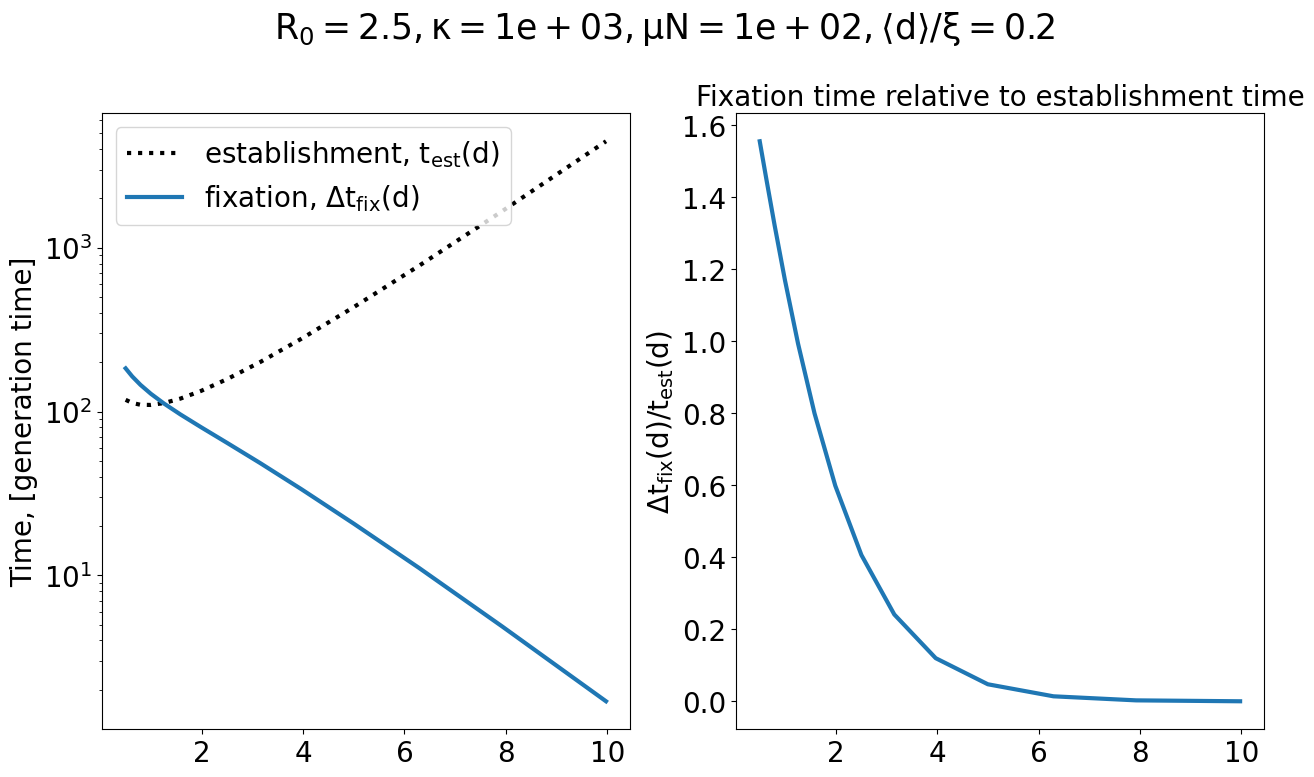

In [47]:
fig,ax =plt.subplots(1,2,figsize=(15,8))

ax[0].plot(ds/dbar,np.array(test_list), linestyle=':', color='k',label = 'establishment, $t_\mathrm{est}(d)$')
ax[0].plot(ds/dbar,np.array(tfix_exact_s_list) - np.array(test_list) ,label = r'fixation, $\Delta t_\mathrm{fix}(d)$')
# ax[0].plot(ds/dbar, 100*np.exp(-2*ds/(xi)))

ax[1].plot(ds/dbar,np.array(tfix_exact_s_list)/np.array(test_list)-1)


# ax[1].axvline(2)
# ax[1].axvline(3)
# ax[1].axvline(4)
# ax[0].set_ylim(1e-4,1e3)

ax[0].legend(loc='best', fontsize=20)
for a in ax:
    # a.set_xlabel(r'Antigenic effect $d/\langle d\rangle}$', fontsize=20)
    a.set_ylabel(r'Time, [generation time]', fontsize=20)
    a.tick_params(axis='both', which='major', labelsize=20)
ax[1].set_title(r'Fixation time relative to establishment time', fontsize=20)
ax[1].set_ylabel(r'$\Delta t_\mathrm{fix}(d)/t_\mathrm{est}(d)$', fontsize=20)
ax[0].set_yscale('log')
fig.suptitle(fr'$R_0={R0}, \kappa={kappa:.0e},\mu N={muN:.0e}, \langle d \rangle/\xi={dbar/xi:.1f}$', fontsize=25, y=1.01)
# plt.savefig(output_folder+f'fixation_vs_establishment_R0_{R0}_kappa_{kappa:.0e}_muN_{muN:.0e}_dbar_{dbar}.pdf',bbox_inches='tight')


In [48]:
p_alpha = .1
dbar= 1/p_alpha

In [49]:
T = np.min(ts[y<1/N])
print(T)

lin_sel_d = lambda t, d, xi, R0,kappa: zp(R0,kappa) * (1 - c_d(d/xi)) \
    + (R0 * t * (zinf(R0,kappa) - zp(R0,kappa)) * (1 - c_d(d/xi)))/kappa
tfix_lin_s = lambda t, d,xi, R0,kappa,N: np.sqrt(t**2+2*kappa/R0 /((1-c_d(d/xi))*zinf(R0,kappa))*np.log(N*yp(R0,kappa)*lin_sel_d(t,d,xi, R0, kappa)))

3852.895440416013


In [50]:
ds2 = np.arange(1,10*dbar)

kappa=1e3
muN= 1e2

ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]
dt = ts[1]-ts[0]
T = np.min(ts[y<1/N])

# for muN in [10,100,1000]:
# for muN in [100]:
var_tfix = 1000

quadratic_Sigma_d_function = lambda t,d, R0,kappa,xi: (1- np.exp(-d/xi))* R0/(kappa) *yp(R0,kappa)*zinf(R0,kappa)* t**2/2
Q_Sigma_d_arr = np.array([quadratic_Sigma_d_function(ts,d, R0,kappa,xi) for d in ds2])

quadratic_Sigma_d_function_capped = lambda t,d, R0,kappa,xi: (1- np.exp(-d/xi))*np.minimum(R0* t**2/(2*kappa) *yp(R0,kappa)*zinf(R0,kappa), -zinf(R0,kappa)-np.log(1-zinf(R0,kappa)))
Q_Sigma_d_arr_capped = np.array([quadratic_Sigma_d_function_capped(ts,d, R0,kappa,xi) for d in ds2])

phi_t_d = np.array([[tfix_lin_s(t,d,xi, R0,kappa,N) for t in ts] for d in ds2])

rho_d_arr=  np.array([np.exp(-(d-1)/dbar)/dbar for d in ds2])
rho_d_arr = rho_d_arr/np.sum(rho_d_arr)

exponent = muN*Q_Sigma_d_arr*rho_d_arr.reshape((len(ds2),1))

F_arr = (1-np.exp(-muN*Q_Sigma_d_arr*rho_d_arr.reshape((len(ds2),1))))#*rho_d_arr.reshape((len(ds2),1))
# * np.sqrt(np.pi/2)*var_tfix *(1 + sps.erf((T - phi_t_d)/np.sqrt(2*var_tfix))) 
F_arr_capped = (1-np.exp(-muN*Q_Sigma_d_arr_capped*rho_d_arr.reshape((len(ds2),1))))#*rho_d_arr.reshape((len(ds2),1))
 #* np.sqrt(np.pi/2)*var_tfix *(1 + sps.erf((T - phi_t_d)/np.sqrt(2*var_tfix)))


Text(0.5, 1.01, '$R_0=2.5, \\kappa=1e+03,\\mu N=1e+02,\\langle d \\rangle/\\xi=0.2$')

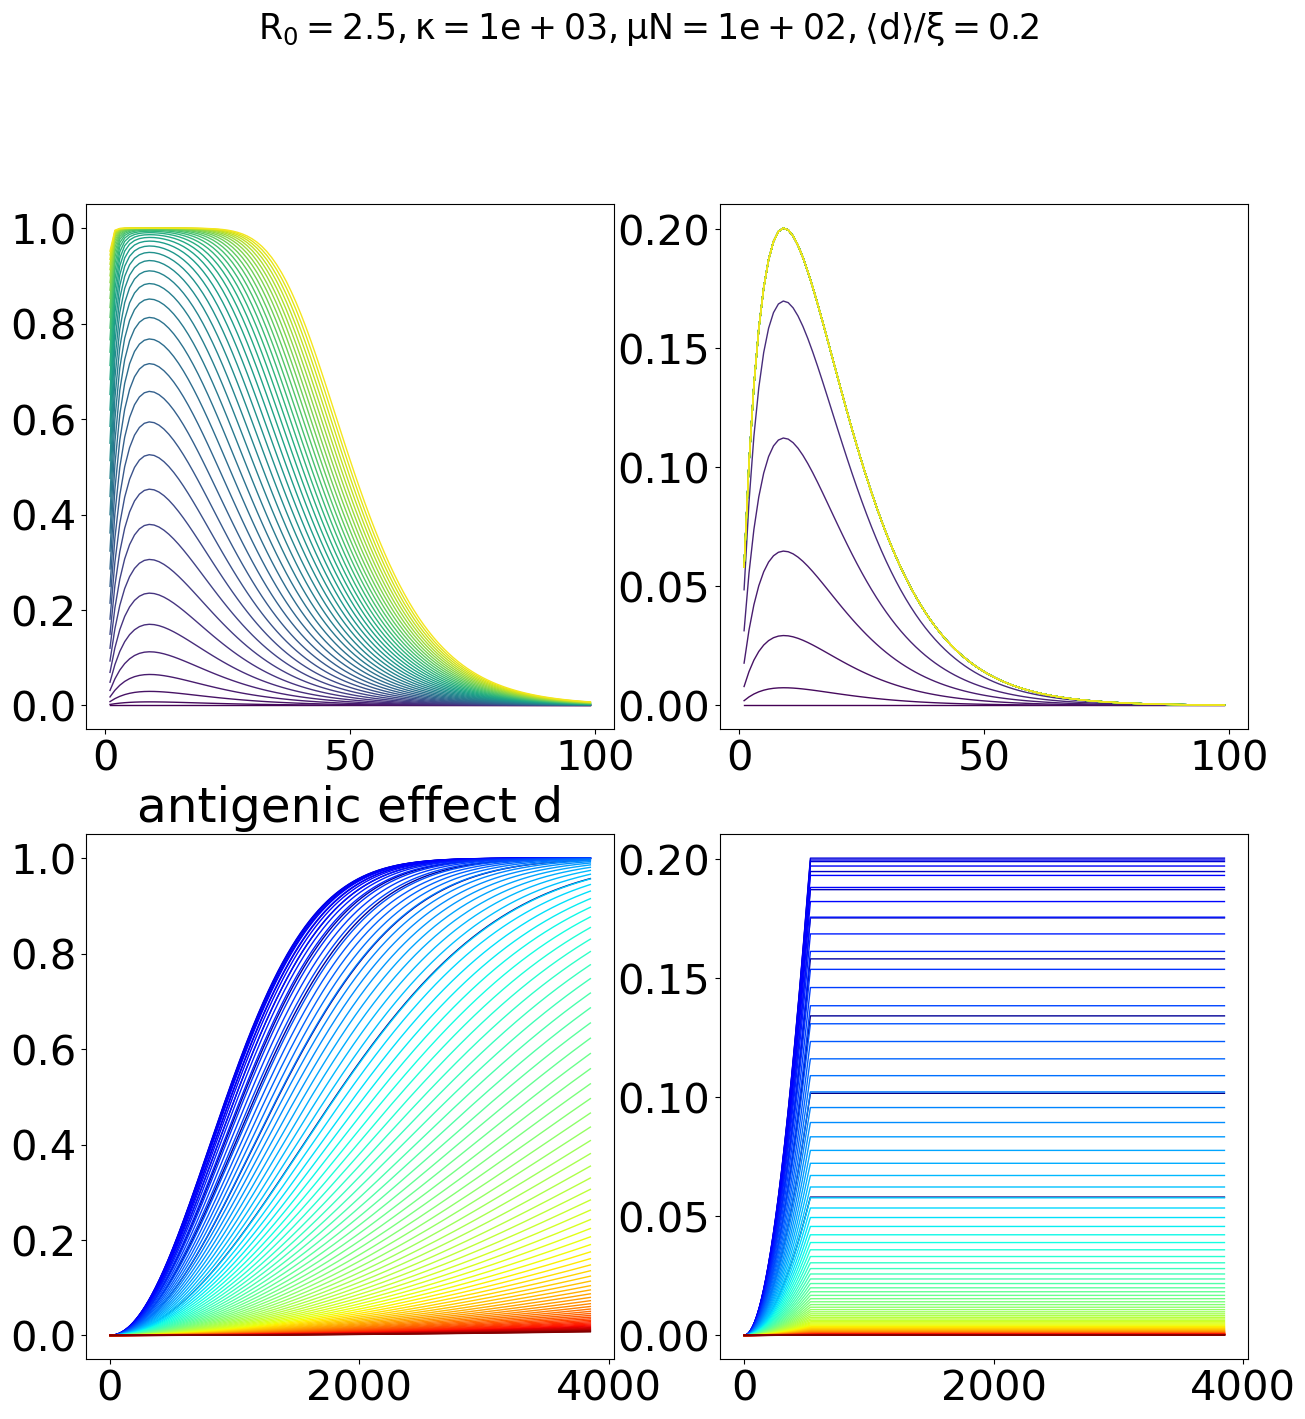

In [51]:

color_ts = dict(zip(ts[ts<T],plt.cm.viridis(np.linspace(0,1,len(ts[ts<T])))))
color_ds = dict(zip(ds2,plt.cm.jet(np.linspace(0,1,len(ds2)))))

fig,ax = plt.subplots(2,2,figsize=(15,15))
plt.subplots_adjust(wspace=.2)
ax= ax.flatten()

for i in range(0,len(ts[ts<T]),100):
    t= ts[i]
    ax[0].plot(ds2, F_arr[:,i], label = f't={t:.2f}', color = color_ts[t],lw=1)
    ax[1].plot(ds2, F_arr_capped[:,i], label = f't={t:.2f}', color = color_ts[t],lw=1)
    # d_F_arr_max,F_arr_max = ds2[np.argmax(F_arr[:,i])], np.max(F_arr[:,i])
    # ax[0].scatter(d_F_arr_max,F_arr_max, color = color_ts[t])

for id, d in enumerate(ds2):
    ax[2].plot(ts[ts<T], F_arr[id][ts<T], label = f'd={d}', color = color_ds[d],lw=1)
    ax[3].plot(ts[ts<T], F_arr_capped[id][ts<T], label = f'd={d}', color = color_ds[d],lw=1)
    
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
# ax[0].set_ylim(1e-3,1e-1)
ax[0].set_xlabel('antigenic effect d')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
# ax[1].set_ylim(1e-3,1e-1)
fig.suptitle(fr'$R_0={R0}, \kappa={kappa:.0e},\mu N={muN:.0e},\langle d \rangle/\xi={dbar/xi:.1f}$', fontsize=25, y=1.01)

Text(0.5, 1.01, '$R_0=2.5, \\kappa=1e+03,\\mu N=1e+02,\\langle d \\rangle/\\xi=0.2$')

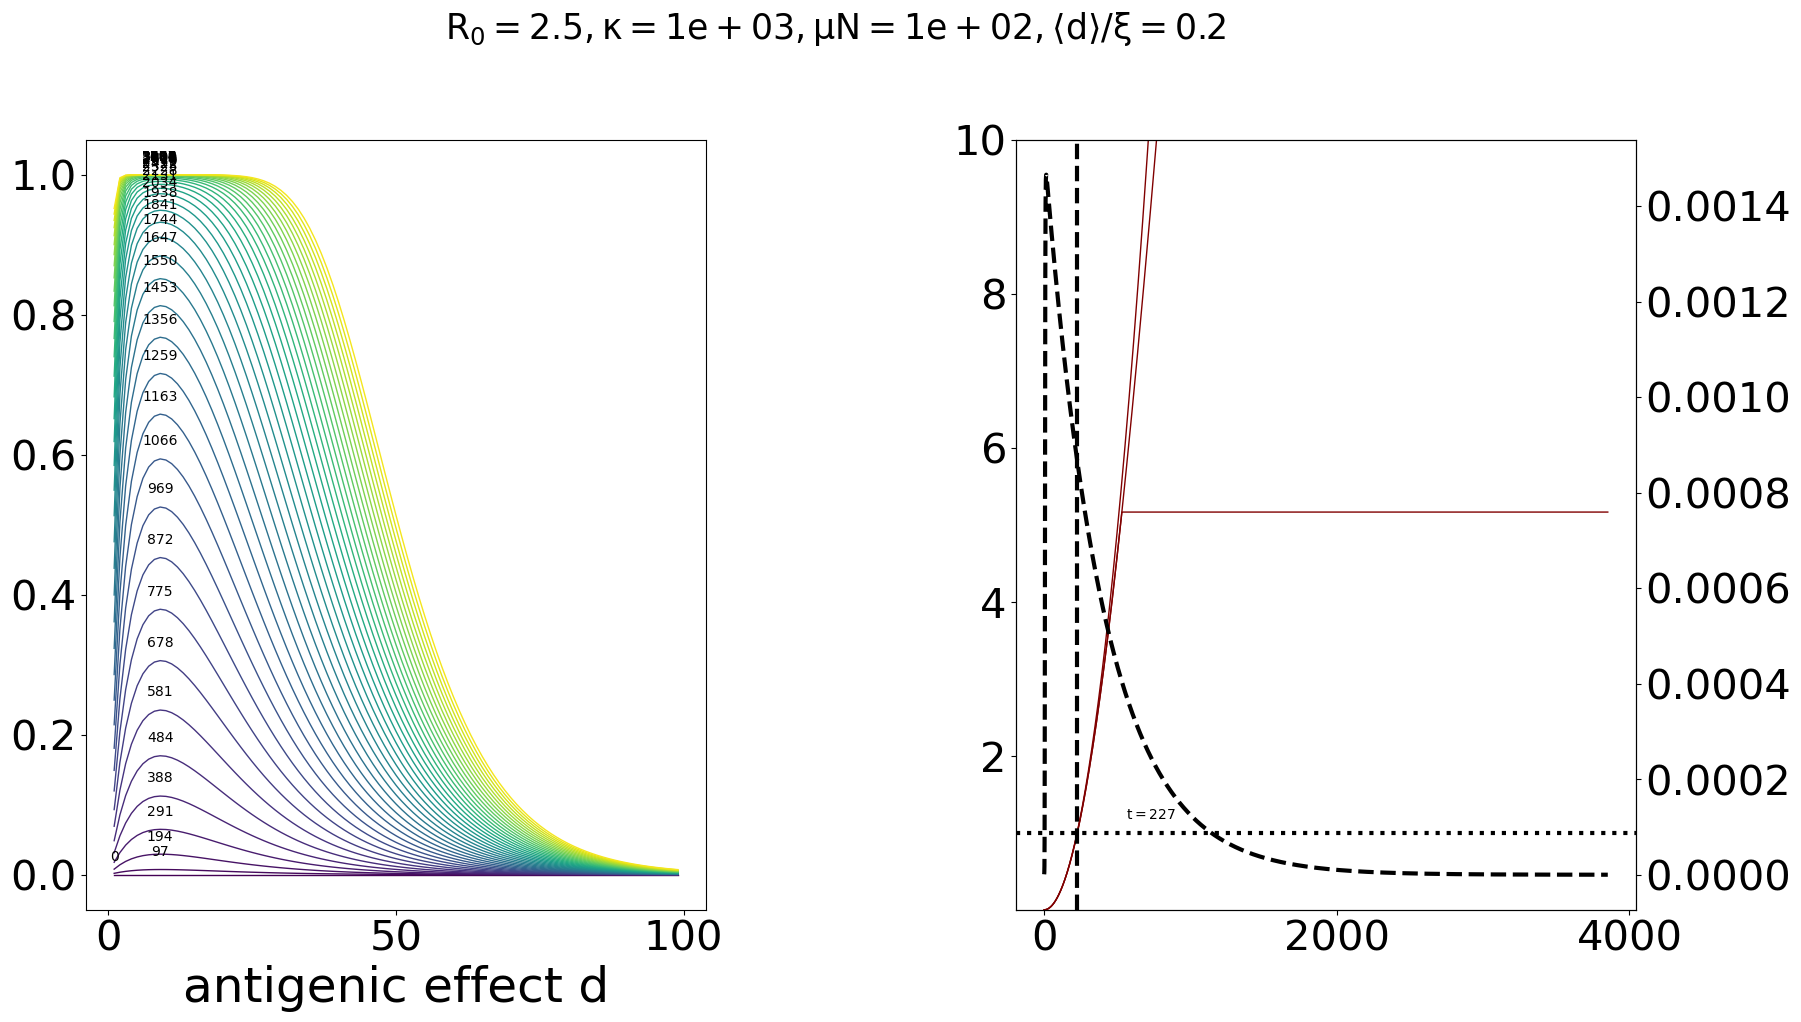

In [52]:

color_ts = dict(zip(ts[ts<T],plt.cm.viridis(np.linspace(0,1,len(ts[ts<T])))))
color_ds = dict(zip(ds2,plt.cm.jet(np.linspace(0,1,len(ds2)))))

fig,ax = plt.subplots(1,2,figsize=(20,10))
plt.subplots_adjust(wspace=.5)
ax= ax.flatten()

for i in range(0,len(ts[ts<T]),100):
    t= ts[i]
    ax[0].plot(ds2, F_arr[:,i], label = f't={t:.2f}', color = color_ts[t],lw=1)
    
    dmax, Fmax = ds2[np.argmax(F_arr[:,i])], np.max(F_arr[:,i])
    ax[0].annotate(f'{t:.0f}', (dmax,Fmax), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

    # d_F_arr_max,F_arr_max = ds2[np.argmax(F_arr[:,i])], np.max(F_arr[:,i])
    # ax[0].scatter(d_F_arr_max,F_arr_max, color = color_ts[t])

# for id, d in enumerate(ds2):
ax[1].plot(ts[ts<T], np.sum(F_arr[:,ts<T], axis=0), label = f'd={d}', color = color_ds[d],lw=1)
ax[1].plot(ts[ts<T], np.sum(F_arr_capped[:,ts<T], axis=0), label = f'd={d}', color = color_ds[d],lw=1)
ax[1].plot(ts[ts<T], np.sum(exponent[:,ts<T], axis=0), label = f'd={d}', color = color_ds[d],lw=1)
ax[1].axhline(1,color='k',ls=':')

t_int_1 = ts[ts<T][np.argmin((np.sum(F_arr[:,ts<T], axis=0)-1)**2)]
ax[1].axvline(t_int_1, color='k', linestyle='--')
ax[1].annotate(fr'$t={t_int_1:.0f}$', (t_int_1+500,1), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
# ax[0].set_ylim(1e-3,1e-1)
ax[0].set_xlabel('antigenic effect d')

# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax[1].set_ylim(1e-3,10)
tax1= ax[1].twinx()
tax1.plot(ts[ts<T], y[ts<T], color='k', linestyle='--')

fig.suptitle(fr'$R_0={R0}, \kappa={kappa:.0e},\mu N={muN:.0e},\langle d \rangle/\xi={dbar/xi:.1f}$', fontsize=25, y=1.01)

In [53]:
tp

14.531916420980687

In [54]:
ts[ts<T][range(0,len(ts[ts<T]),100)]

array([   0.        ,   96.87944281,  193.75888561,  290.63832842,
        387.51777123,  484.39721403,  581.27665684,  678.15609965,
        775.03554245,  871.91498526,  968.79442807, 1065.67387087,
       1162.55331368, 1259.43275648, 1356.31219929, 1453.1916421 ,
       1550.0710849 , 1646.95052771, 1743.82997052, 1840.70941332,
       1937.58885613, 2034.46829894, 2131.34774174, 2228.22718455,
       2325.10662736, 2421.98607016, 2518.86551297, 2615.74495578,
       2712.62439858, 2809.50384139, 2906.3832842 , 3003.262727  ,
       3100.14216981, 3197.02161262, 3293.90105542, 3390.78049823,
       3487.65994104, 3584.53938384, 3681.41882665, 3778.29826945])

In [55]:
ts_relevant = ts[ts<T]
# muN=10

In [56]:
rate_d_t_function = lambda t,d, R0,kappa,xi, p_alpha: p_alpha*(1-p_alpha)**(d-1) * (1- np.exp(-d/xi))* R0/(kappa) *yp(R0,kappa)*zinf(R0,kappa)* t

rate_d_t = muN*np.array([[rate_d_t_function(t,d, R0,kappa,xi,p_alpha) for t in ts_relevant] for d in ds2])

In [57]:
#turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [58]:
rate_t = np.sum(rate_d_t,axis=0)

n_d_t = np.cumsum(rate_d_t,axis=1)*dt
n_t = np.sum(n_d_t,axis=0)

p_test_smaller_t = (1-np.exp(-n_t))
p_test_smaller_t_d = n_d_t/n_t * (1-np.exp(-n_t))

grad_t_n_d_t = np.gradient(n_d_t,dt,axis=1)
grad_t_n_t = np.gradient(n_t,dt)

p_est_t = grad_t_n_t*np.exp(-n_t)

A_d_t = grad_t_n_d_t/n_t - grad_t_n_t*n_d_t/(n_t**2)
B_d_t = n_d_t*grad_t_n_t/n_t
p_est_d_t = (1-np.exp(-n_t))*A_d_t + B_d_t*np.exp(-n_t)



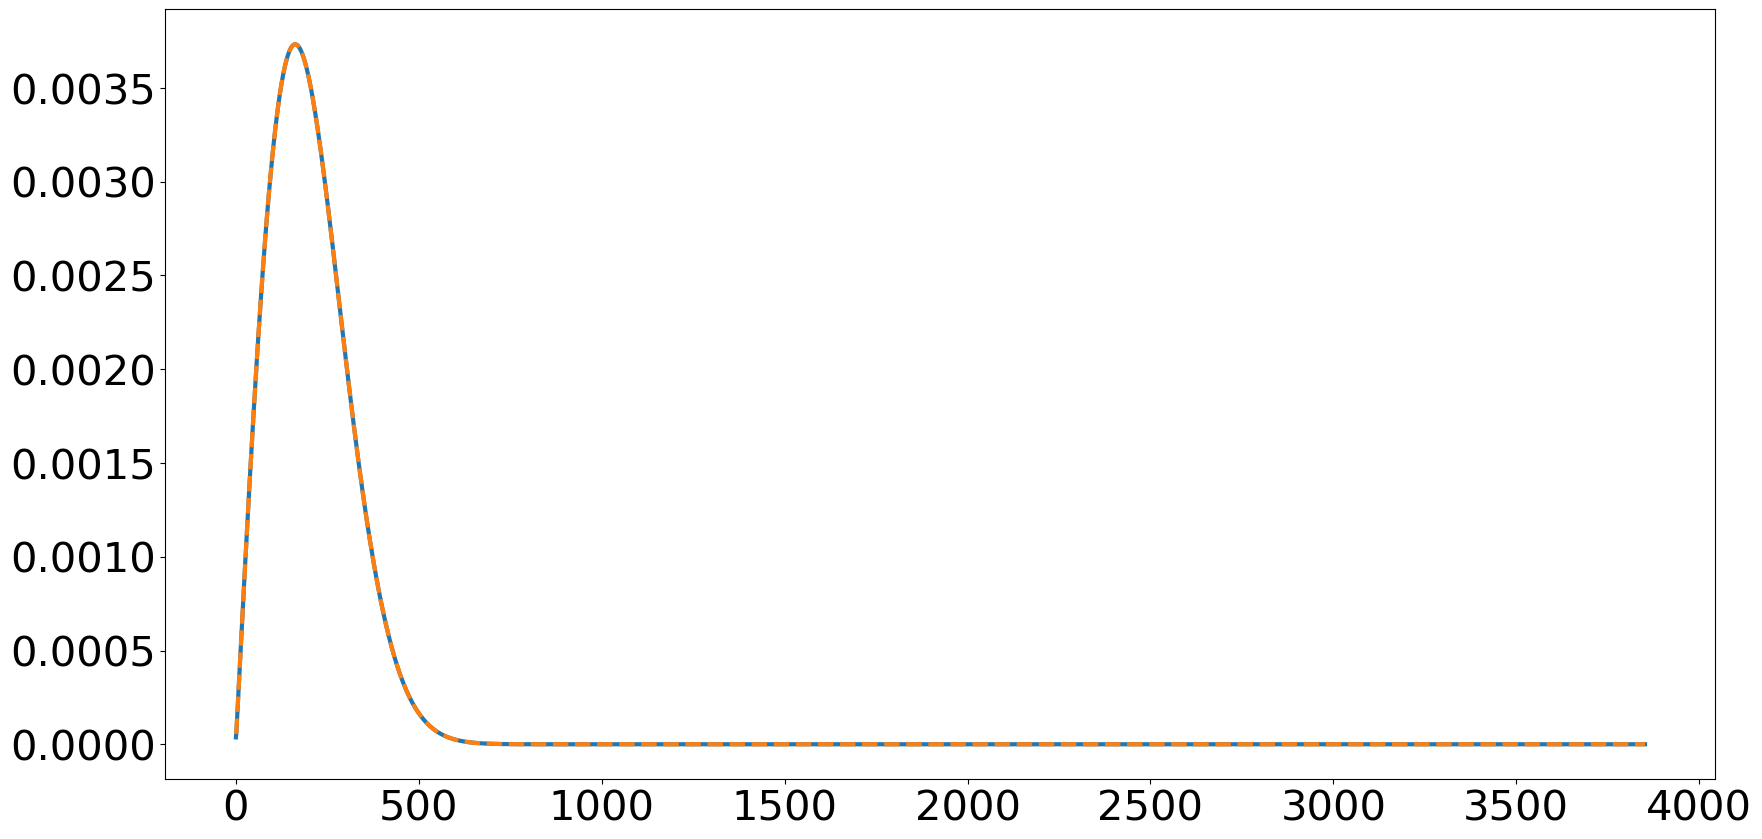

In [59]:
fig,ax= plt.subplots(figsize=(20,10))

ax.plot(ts_relevant, p_est_t, label='p_test(t)')
ax.plot(ts_relevant, np.sum(p_est_d_t,axis=0), label='p_test(t)',linestyle='--')

In [60]:
p_est_test_d = np.gradient(p_test_smaller_t_d,dt,axis=1)
p_est_test = np.sum(p_est_test_d,axis=0)

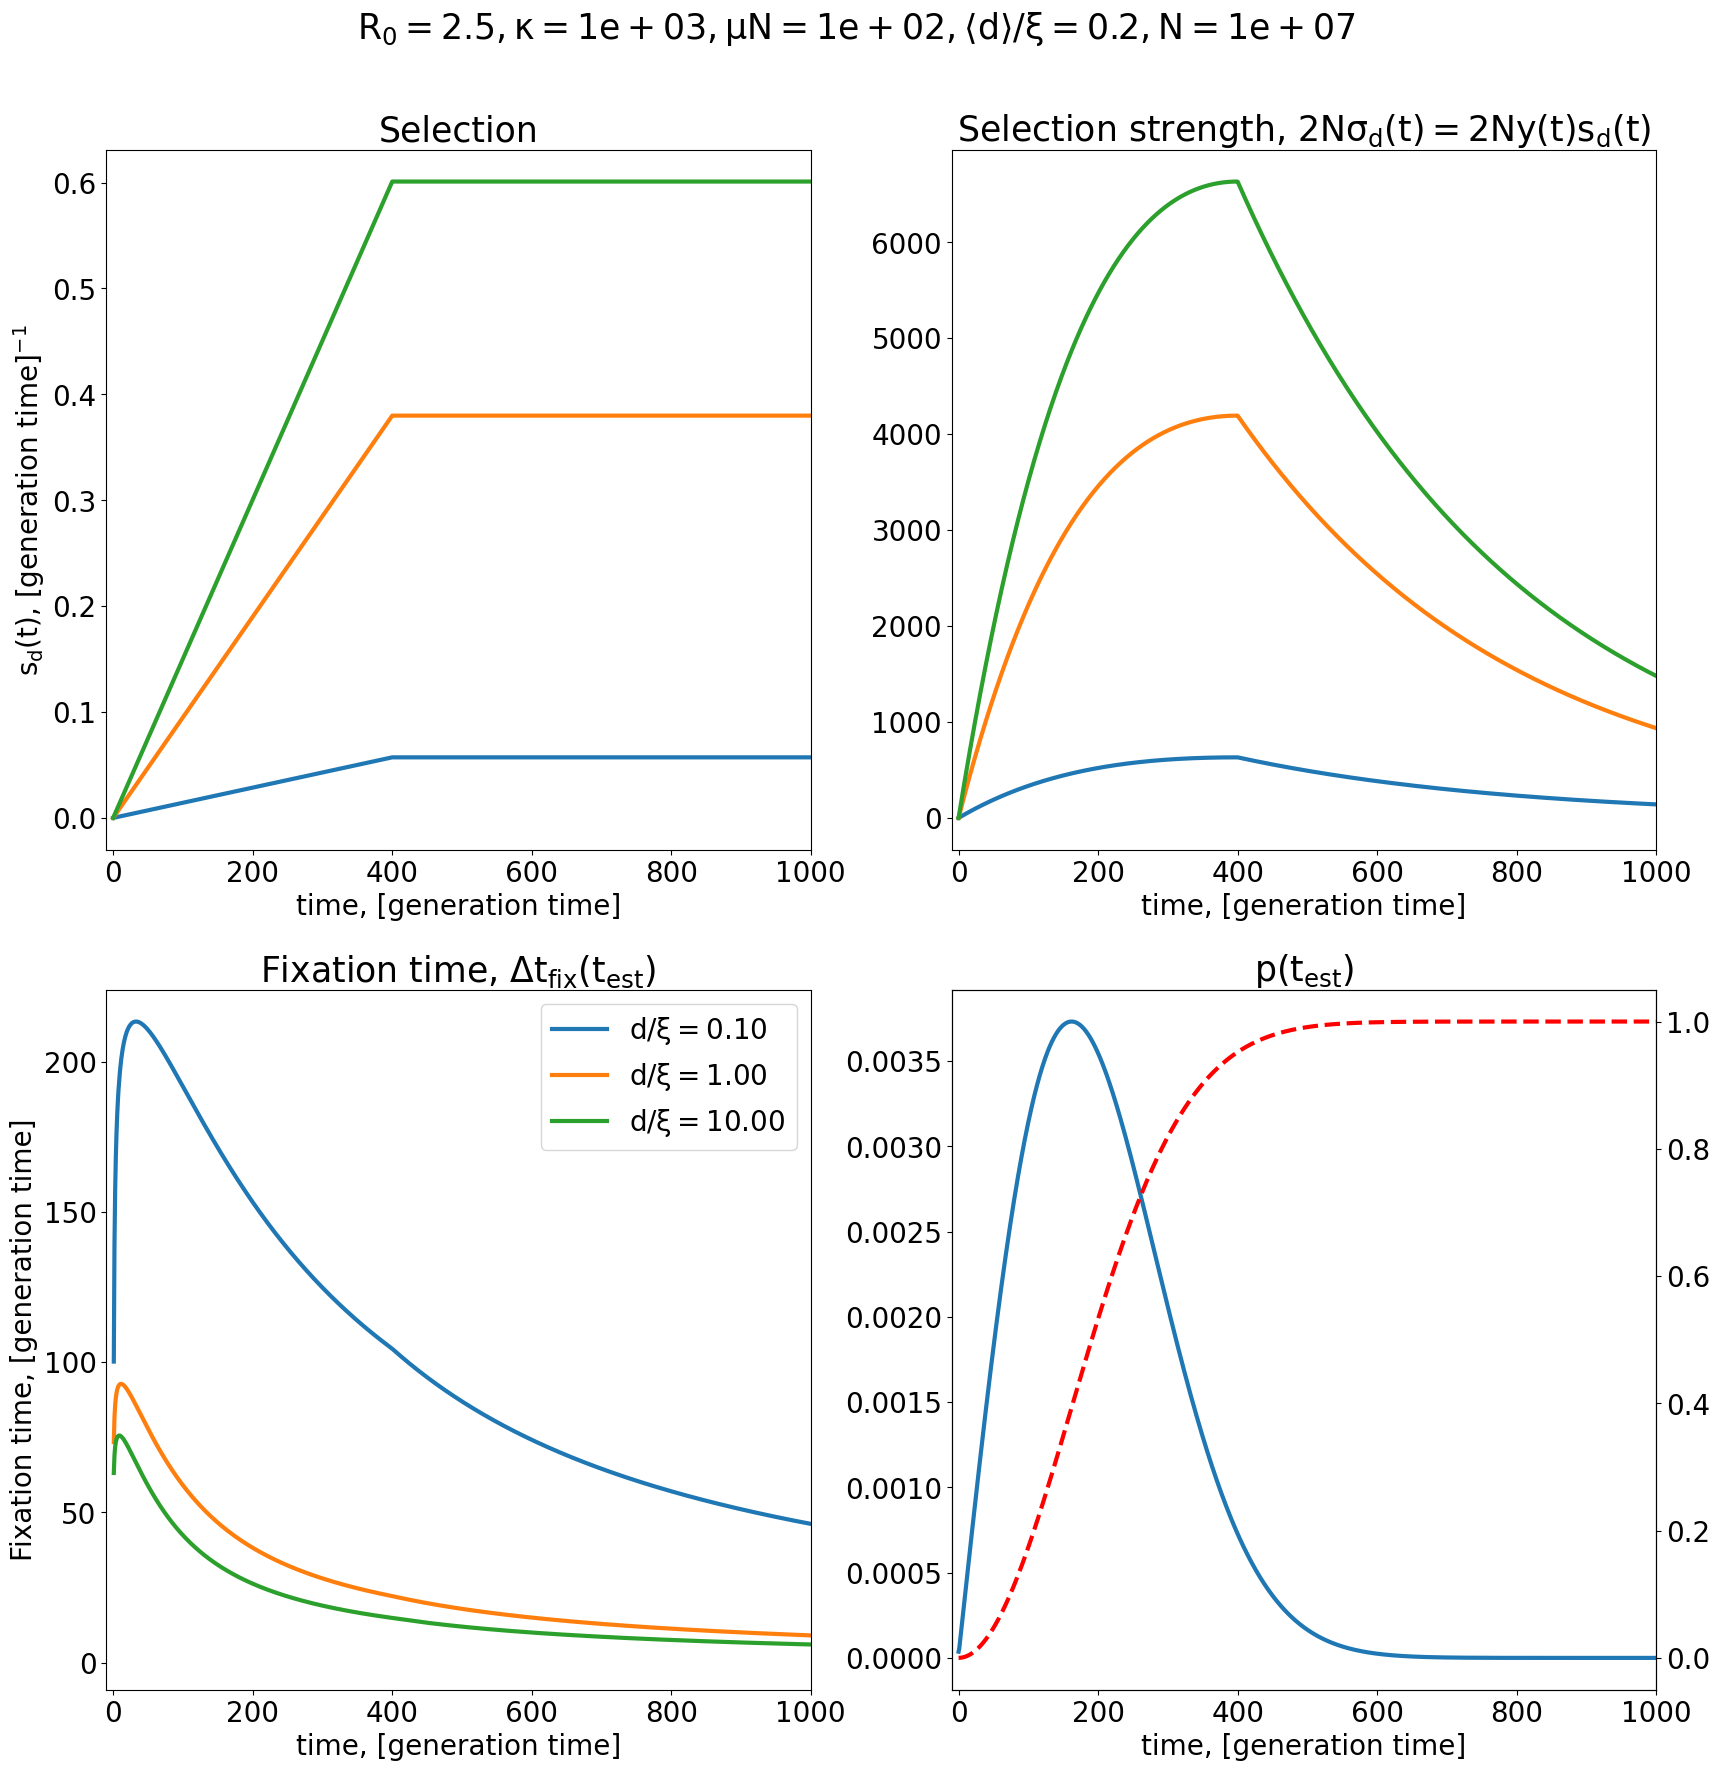

In [61]:
fig,ax= plt.subplots(2,2,figsize=(20,20))
ax= ax.flatten()
for d in ds_few:
    sel_d = (1-c_d(d/xi))*zinf(R0,kappa)*np.minimum(R0*ts_relevant/kappa,np.ones_like(ts_relevant))
    y_exp = yp(R0,kappa)*np.exp(-R0/kappa*ts_relevant)
    tfix = np.sqrt(ts_relevant**2 + 2*kappa/R0 /((1-c_d(d/xi))*zinf(R0,kappa))*np.log(N*yp(R0,kappa)*sel_d))-ts_relevant

    ax[0].plot(ts_relevant, sel_d, label = fr'$d/\xi={d/xi:.2f}$')
    ax[1].plot(ts_relevant, 2*N*sel_d*y_exp, label = fr'$d/\xi={d/xi:.2f}$')
    ax[2].plot(ts_relevant, tfix, label = fr'$d/\xi={d/xi:.2f}$')

ax[-1].plot(ts_relevant, p_est_t, label='rate')
tax0= ax[-1].twinx()
tax0.plot(ts_relevant, p_test_smaller_t, color='red', linestyle='--')

for a in [ax[-1], tax0]: a.set_xlim((-10,1000))
for a in [*ax,tax0]:

    a.set_xlim((-10,1000))
    a.tick_params(axis='both', which='major', labelsize=20)
    a.set_xlabel('time, [generation time]', fontsize=20)


ax[0].set_title('Selection', fontsize=subtitles_fontsize)
ax[0].set_ylabel(r'$s_d(t)$, [generation time]$^{-1}$', fontsize=20)

ax[1].set_title(r'Selection strength, $2 N \sigma_d(t) =  2 N y(t) s_d(t)$', fontsize=subtitles_fontsize)
# ax[1].set_ylabel(r'Probability density, [generation time]$^{-1}$', fontsize=20)
ax[2].set_title(r'Fixation time, $\Delta t_{\mathrm{fix}}(t_\mathrm{est})$', fontsize=subtitles_fontsize)
ax[2].set_ylabel(r'Fixation time, [generation time]', fontsize=20)
ax[2].legend(loc='best', fontsize=20)
ax[-1].set_title(r'$p(t_\mathrm{est})$', fontsize=subtitles_fontsize)

fig.suptitle(fr'$R_0={R0}, \kappa={kappa:.0e},\mu N={muN:.0e},\langle d \rangle/\xi={dbar/xi:.1f}, N={N:.0e}$', fontsize=25, y=.95)

plt.savefig(output_folder+f'a1.pdf',bbox_inches='tight')

In [62]:
np.argmin((n_t-1)**2)

237

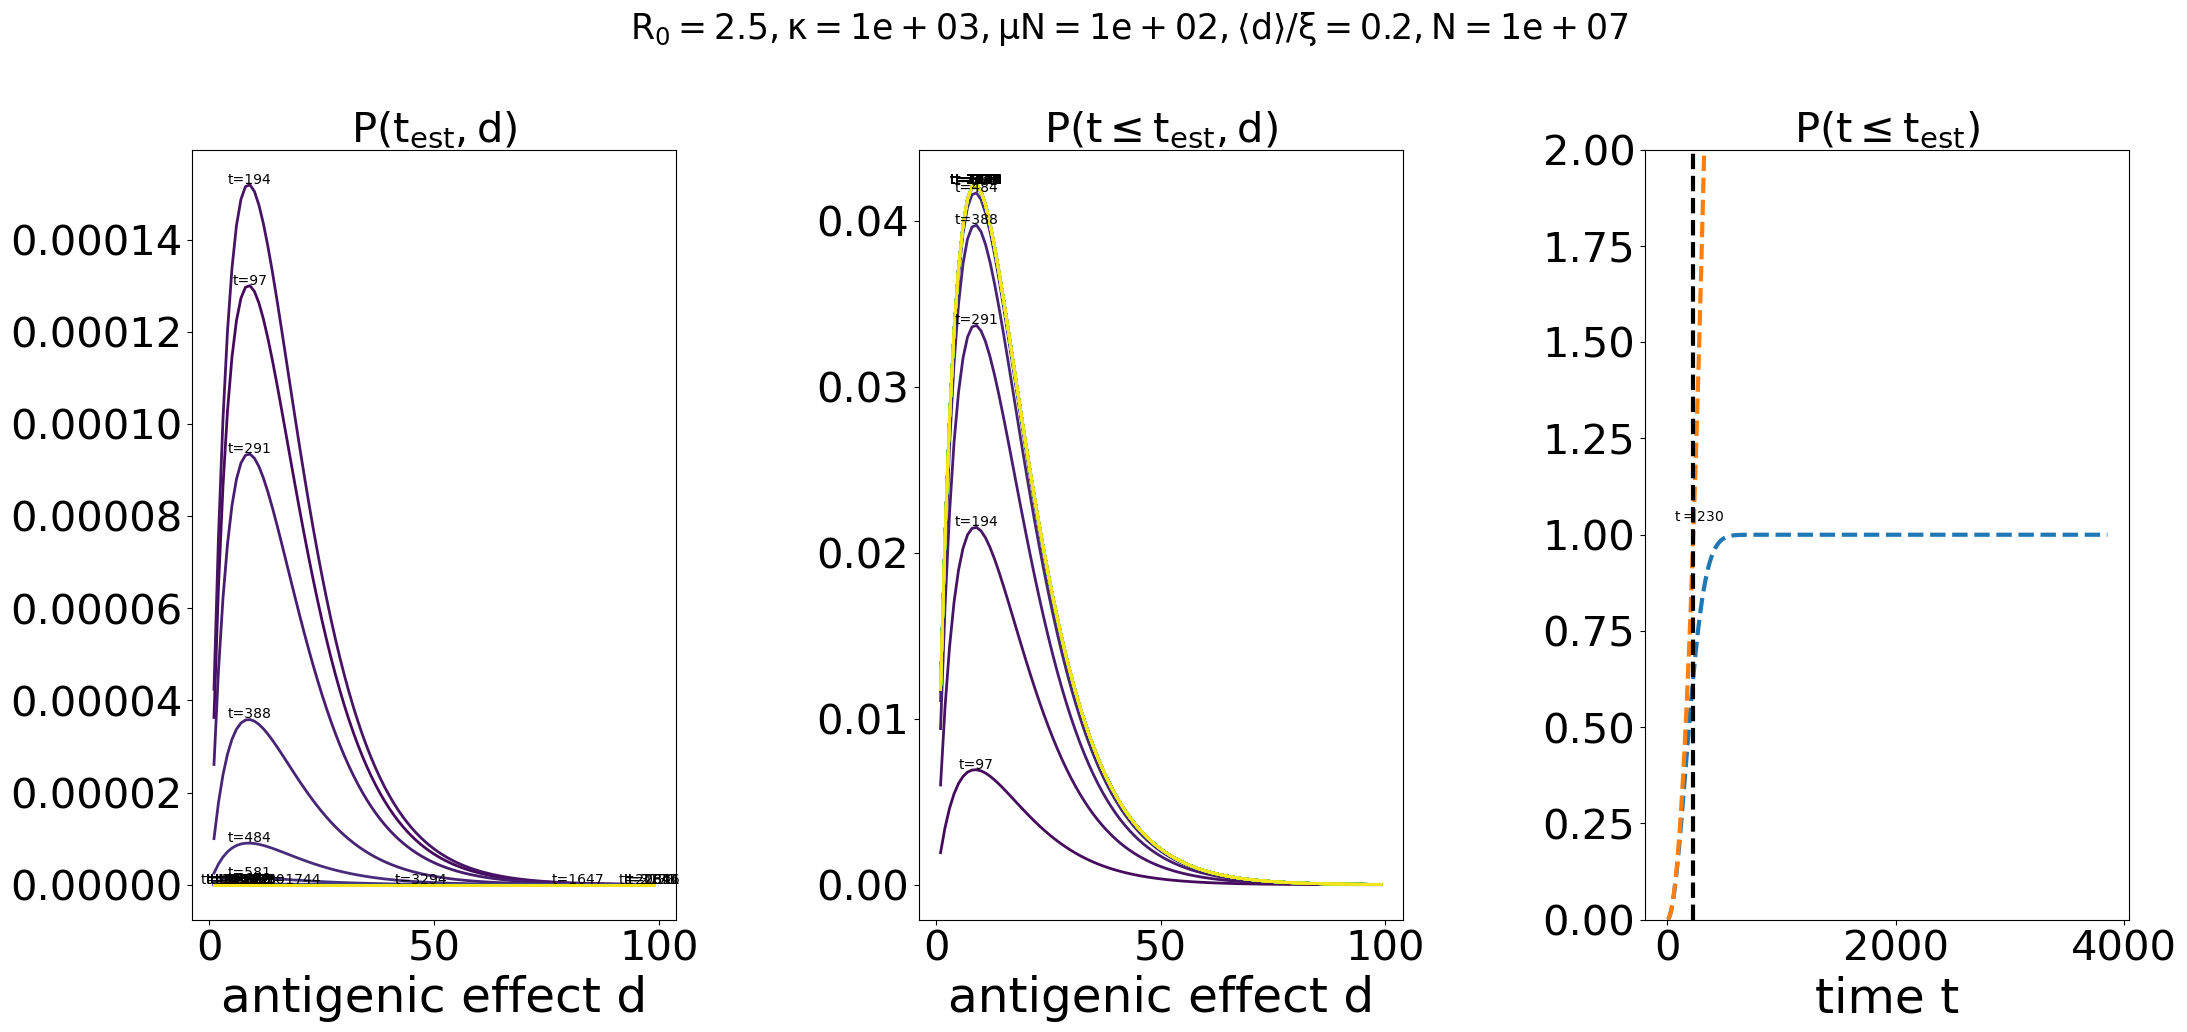

In [63]:
fig,ax= plt.subplots(1,3,figsize=(25,10))
plt.subplots_adjust(wspace=.5)
for i in range(0,len(ts[ts<T]),100):
    t= ts[i]
    ax[0].plot(ds2, p_est_test_d[:,i], label = f't={t:.2f}', color = color_ts[t],lw=2)
    peak_d, peak_p = ds2[np.argmax(p_est_test_d[:,i])], np.max(p_est_test_d[:,i])
    ax[0].annotate(f't={t:.0f}', (peak_d,peak_p), textcoords="offset points", xytext=(0,1), ha='center', fontsize=10)

    ax[1].plot(ds2, p_test_smaller_t_d[:,i], label = f't={t:.2f}', color = color_ts[t],lw=2)
    peak_d, peak_p = ds2[np.argmax(p_test_smaller_t_d[:,i])], np.max(p_test_smaller_t_d[:,i])
    ax[1].annotate(f't={t:.0f}', (peak_d,peak_p), textcoords="offset points", xytext=(0,1), ha='center', fontsize=10)

# ax[2].plot(ts_relevant, np.sum(p_test_smaller_t_d,axis=0), label='rate')
ax[2].plot(ts_relevant, p_test_smaller_t, label='rate',linestyle='--')
ax[2].plot(ts_relevant, n_t, label='rate',linestyle='--')

t_int_1 = ts_relevant[np.argmin((n_t-1)**2)]
ax[-1].axvline(t_int_1, color='k', linestyle='--')
ax[-1].annotate(fr'$t={t_int_1:.0f}$', (t_int_1+50,1), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)


ax[2].set_ylim(0,2)
# ax[0].set_yscale('log')
ax[0].set_xlabel('antigenic effect d')
ax[1].set_xlabel('antigenic effect d')

ax[2].set_xlabel('time t')

ax[0].set_title(r"$P(t_\mathrm{est},d)$",fontsize=30)
ax[1].set_title(r"$P( t\leq t_\mathrm{est},d)$",fontsize=30)
ax[2].set_title(r"$P( t\leq t_\mathrm{est})$",fontsize=30)
fig.suptitle(fr'$R_0={R0}, \kappa={kappa:.0e},\mu N={muN:.0e},\langle d \rangle/\xi={dbar/xi:.1f}, N={N:.0e}$', fontsize=25, y=1.02)
plt.savefig(output_folder+f'a2.pdf',bbox_inches='tight')

 avg_t1 = 202.69
 var_t1 = 11277.55
 std t1 = 106.20

 avg_t2 = 304.52
 avg_d_avg_t1 = 17.47
 var_d_avg_t1 = 152.25
 std d_avg_t1 = 12.34


Text(0.5, 1.02, '$R_0=2.5, \\kappa=1e+03,\\mu N=1e+02,\\langle d \\rangle/\\xi=0.2, N=1e+07$')

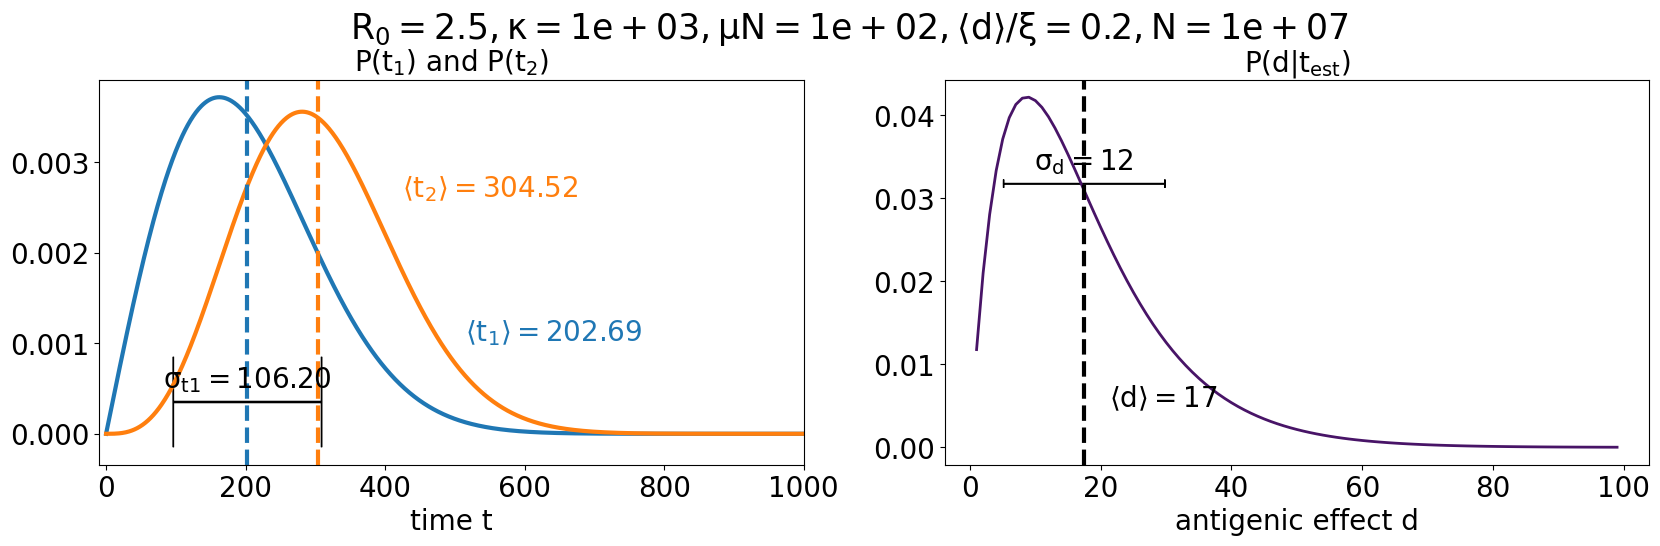

In [64]:
fig,ax= plt.subplots(1,2,figsize=(20,5))
for a in ax: 
    a.tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlim((-10,1000))

p_t1 = rate_t*np.exp(-n_t)
p_t2 = rate_t*n_t*np.exp(-n_t)

l_t1, =ax[0].plot(ts_relevant, p_t1)
l_t2, =ax[0].plot(ts_relevant, p_t2)

avg_t1 = np.sum(p_t1*ts_relevant)*dt
print(f' avg_t1 = {avg_t1:.2f}')
var_t1= np.sum(p_t1*(ts_relevant-avg_t1)**2)*dt
print(f' var_t1 = {var_t1:.2f}')
print(f' std t1 = {np.sqrt(var_t1):.2f}')
print()

ax[0].arrow(x = avg_t1- np.sqrt(var_t1), y = p_t1[np.argmin((ts_relevant-avg_t1)**2)]/10, dx = 2*np.sqrt(var_t1), dy = 0, color='k', head_width=.001, head_length=0.01,width=.00001,shape='full')
ax[0].arrow(x = avg_t1+ np.sqrt(var_t1), y = p_t1[np.argmin((ts_relevant-avg_t1)**2)]/10, dx = -2*np.sqrt(var_t1), dy = 0, color='k', head_width=.001, head_length=0.01,width=.00001,shape='full')
ax[0].annotate( fr'$\sigma_{{t1}} = {np.sqrt(var_t1):.2f}$', (avg_t1, p_t1[np.argmin((ts_relevant-avg_t1)**2)]/10), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)

ax[0].annotate( fr'$\langle t_1\rangle = {avg_t1:.2f}$', (ts_relevant[len(ts_relevant)//6], p_t1[len(ts_relevant)//10]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20, color=l_t1.get_color())
ax[0].axvline(avg_t1, color=l_t1.get_color(), linestyle='--')

avg_t2 = np.sum(p_t2*ts_relevant)*dt
print(f' avg_t2 = {avg_t2:.2f}')
ax[0].annotate( fr'$\langle t_2\rangle = {avg_t2:.2f}$', (ts_relevant[len(ts_relevant)//7], p_t2[len(ts_relevant)//10]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20, color=l_t2.get_color())
ax[0].axvline(avg_t2, color=l_t2.get_color(), linestyle='--')

p_test_given_d = p_est_test_d/p_est_t

ind_avg_t1 = np.arange(len(ts_relevant))[np.argmin((ts_relevant-avg_t1)**2)]
avg_t1_on_ts = ts_relevant[ind_avg_t1]

ax[1].plot(ds2, p_test_given_d[:,ind_avg_t1], label = f't={avg_t1_on_ts:.2f}', color = color_ts[avg_t1_on_ts],lw=2)
avg_d_avg_t1 = np.sum(p_test_given_d[:,ind_avg_t1]*ds2)
print(f' avg_d_avg_t1 = {avg_d_avg_t1:.2f}')
var_d_avg_t1 = np.sum(p_test_given_d[:,ind_avg_t1]*(ds2-avg_d_avg_t1)**2)
print(f' var_d_avg_t1 = {var_d_avg_t1:.2f}')
print(f' std d_avg_t1 = {np.sqrt(var_d_avg_t1):.2f}')

#arrow indicating width of the distribbution

ax[1].arrow(x = avg_d_avg_t1- np.sqrt(var_d_avg_t1), y = p_test_given_d[np.argmin((ds2-avg_d_avg_t1)**2),ind_avg_t1], dx = 2*np.sqrt(var_d_avg_t1), dy = 0, color='k', head_width=.001, head_length=0.01,width=.00001,shape='full')
ax[1].arrow(x = avg_d_avg_t1+ np.sqrt(var_d_avg_t1), y = p_test_given_d[np.argmin((ds2-avg_d_avg_t1)**2),ind_avg_t1], dx = -2*np.sqrt(var_d_avg_t1), dy = 0, color='k', head_width=.001, head_length=0.01,width=.00001,shape='full')
ax[1].annotate( fr'$\sigma_d = {np.sqrt(var_d_avg_t1):.0f}$', (avg_d_avg_t1, p_test_given_d[np.argmin((ds2-avg_d_avg_t1)**2),ind_avg_t1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)

ax[1].axvline(avg_d_avg_t1, color='k', linestyle='--')
ax[1].annotate( fr'$\langle d\rangle = {avg_d_avg_t1:.0f}$', (avg_d_avg_t1+12, p_test_given_d[np.argmin((ds2-avg_d_avg_t1)**2),ind_avg_t1]/10), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)

ax[0].set_xlabel('time t', fontsize=20)
ax[1].set_xlabel('antigenic effect d', fontsize=20)

ax[0].set_title(r"$P(t_1)$ and $P(t_2)$",fontsize=20)
ax[1].set_title(r"$P(d|t_\mathrm{est})$",fontsize=20)
fig.suptitle(fr'$R_0={R0}, \kappa={kappa:.0e},\mu N={muN:.0e},\langle d \rangle/\xi={dbar/xi:.1f}, N={N:.0e}$', fontsize=25, y=1.02)
# plt.savefig(output_folder+f'a3.pdf',bbox_inches='tight')

In [65]:
ds2

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 91.,
       92., 93., 94., 95., 96., 97., 98., 99.])